Workflow for getting ball counts

Mermaid Chart - Create complex, visual diagrams with text. A smarter way of creating diagrams.-2025-08-12-052323.svg

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import os, glob
import numpy as np
import pandas as pd

# for colored Excel output
try:
    from openpyxl.styles import PatternFill
except ImportError:
    import sys
    !{sys.executable} -m pip install -q openpyxl
    from openpyxl.styles import PatternFill

# ===== CONFIG =====
ROOT = '/content/drive/MyDrive/Winrate predictions'
TOTAL_BALLS = 6
START_BALLS_PER_SIDE = 3
ALIVE0_COL = 'team 0 left'
ALIVE1_COL = 'team 1 left'

# Keep-only columns for SLIM file (by Excel letters)
SLIM_LETTERS = ['A','B','C','D','E','F','J','L','M','AA','AB','AC','AM']

# ===== helpers =====
def _excel_letters_to_idx(col_letters: str) -> int:
    """Convert Excel letters (e.g., 'A','Z','AA','AM') to 0-based index."""
    s = str(col_letters).strip().upper()
    idx = 0
    for ch in s:
        idx = idx * 26 + (ord(ch) - ord('A') + 1)
    return idx - 1  # zero-based

def pick_cols_by_letters(df: pd.DataFrame, letters) -> list:
    """Return column names from df matching Excel letter positions."""
    cols = []
    for L in letters:
        i = _excel_letters_to_idx(L)
        if 0 <= i < len(df.columns):
            cols.append(df.columns[i])
        else:
            print(f"[WARN] Letter {L} -> index {i} out of bounds for {len(df.columns)} columns; skipping.")
    return cols

def anchor_from_set_throw(row, alive0, alive1):
    if not (bool(row.get('is_phase1')) and str(row.get('phase1_category')) == 'set_throw'):
        return (None, None, None)
    if pd.isna(alive0) or pd.isna(alive1):
        return (None, None, None)

    side = int(row['team']) if pd.notna(row['team']) else 0
    inzone0 = int(row['t0_zone']) if pd.notna(row.get('t0_zone')) else 0
    inzone1 = int(row['t1_zone']) if pd.notna(row.get('t1_zone')) else 0
    inzone_side = inzone1 if side == 1 else inzone0

    alive0 = int(alive0); alive1 = int(alive1)
    alive_side = alive1 if side == 1 else alive0
    alive_opp  = alive0 if side == 1 else alive1

    basic = alive_side > inzone_side
    logic = alive_side < alive_opp

    side_balls = None
    if basic:
        side_balls = inzone_side
    if logic:
        side_balls = max(4, side_balls if side_balls is not None else 0)
    if side_balls is None:
        return (None, None, None)

    side_balls = int(max(0, min(side_balls, TOTAL_BALLS)))
    opp_balls  = TOTAL_BALLS - side_balls
    reason = 'set_throw_basic_and_logic' if (basic and logic) else ('set_throw_basic' if basic else 'set_throw_logic')
    t0a, t1a = (side_balls, opp_balls) if side == 0 else (opp_balls, side_balls)
    return (t0a, t1a, reason)

def simulate_segment_naive(seg, t0_start, t1_start):
    t0, t1 = int(t0_start), int(t1_start)
    t0_list, t1_list = [], []
    for _, r in seg.iterrows():
        tm = int(r['team']) if pd.notna(r['team']) else 0
        if tm == 0:
            if t0 > 0: t0 -= 1; t1 += 1
        else:
            if t1 > 0: t1 -= 1; t0 += 1
        t0_list.append(t0); t1_list.append(t1)
    return np.array(t0_list), np.array(t1_list)

def reconcile_segment_to_anchor(seg, t0_seq, t1_seq, t0_start, t1_start, t0_target_end):
    """
    Returns:
      t0_new, t1_new       -> recomputed post-throw counts
      transfer_bool        -> True where a transfer still happens, False where we flipped to "rollback"
      residual_gap_t0      -> remaining gap at end (0 means exact match to anchor target)
    """
    curr_t0_end = int(t0_seq[-1])
    diff = t0_target_end - curr_t0_end

    transfer = np.ones(len(seg), dtype=bool)
    if diff != 0:
        need_team = 0 if diff > 0 else 1
        flips_needed = abs(diff)
        flips = 0
        idxs = list(seg.index)
        for k in range(len(idxs)-1, -1, -1):       # latest-first
            if flips >= flips_needed:
                break
            if int(seg.loc[idxs[k], 'team']) == need_team and transfer[k]:
                transfer[k] = False                 # rollback this row
                flips += 1

    t0, t1 = int(t0_start), int(t1_start)
    t0_new, t1_new = [], []
    for k, (_, r) in enumerate(seg.iterrows()):
        if transfer[k]:
            if int(r['team']) == 0:
                if t0 > 0: t0 -= 1; t1 += 1
            else:
                if t1 > 0: t1 -= 1; t0 += 1
        t0_new.append(t0); t1_new.append(t1)

    residual_gap = int(t0_target_end) - int(t0_new[-1])
    return np.array(t0_new), np.array(t1_new), transfer, residual_gap

# ===== per-file =====
def process_events_file(file_path: str):
    try:
        df = pd.read_excel(file_path)
    except Exception as e:
        print(f"[SKIP read] {os.path.basename(file_path)}: {e}")
        return None

    needed = ['set_no','time','team','is_throw','is_phase1','phase1_category','t0_zone','t1_zone', ALIVE0_COL, ALIVE1_COL]
    if any(c not in df.columns for c in needed):
        print(f"[SKIP cols] {os.path.basename(file_path)} missing { [c for c in needed if c not in df.columns] }")
        return None

    df = df.sort_values(['set_no','time']).reset_index(drop=True)

    outputs = []
    anchor_log = []

    for set_no, df_set in df.groupby('set_no', sort=True):
        df_set = df_set.sort_values('time')
        throws = df_set[df_set['is_throw']].copy()
        if throws.empty:
            continue

        throws['orig_idx'] = throws.index

        a0_tbl = df_set[['time', ALIVE0_COL]].drop_duplicates('time', keep='last').rename(columns={ALIVE0_COL:'alive0'}).sort_values('time')
        a1_tbl = df_set[['time', ALIVE1_COL]].drop_duplicates('time', keep='last').rename(columns={ALIVE1_COL:'alive1'}).sort_values('time')
        base = throws[['time']].copy().sort_values('time')
        alive_tbl = pd.merge_asof(base, a0_tbl, on='time', direction='backward')
        alive_tbl = pd.merge_asof(alive_tbl, a1_tbl, on='time', direction='backward')
        throws = pd.concat([throws.reset_index(drop=True), alive_tbl[['alive0','alive1']].reset_index(drop=True)], axis=1)

        anchors = [(-1, START_BALLS_PER_SIDE, START_BALLS_PER_SIDE, 'start_3_3', None)]
        for i, r in throws.reset_index(drop=True).iterrows():
            t0a, t1a, reason = anchor_from_set_throw(r, r.get('alive0', np.nan), r.get('alive1', np.nan))
            if t0a is not None:
                anchors.append((i-1, int(t0a), int(t1a), reason, i))

        # dedupe by apply-to: keep last
        ded = {}
        for ap, t0a, t1a, rsn, trig in anchors:
            ded[ap] = (t0a, t1a, rsn, trig)
        anchors = sorted([(k, *v) for k, v in ded.items()], key=lambda x: x[0])

        # marks
        mark_prev        = pd.Series(False, index=throws.index)
        mark_trigger     = pd.Series(False, index=throws.index)
        mark_reason      = pd.Series('',    index=throws.index, dtype=object)
        mark_t0_target   = pd.Series(np.nan, index=throws.index)
        mark_t1_target   = pd.Series(np.nan, index=throws.index)
        mark_start_seed  = pd.Series(False, index=throws.index)
        mark_residual_gap = pd.Series(np.nan, index=throws.index)
        mark_flips_used   = pd.Series(np.nan, index=throws.index)

        rollback_flag = pd.Series(False, index=throws.index)
        rollback_team = pd.Series(np.nan, index=throws.index)

        if any(ap == -1 for ap, *_ in anchors):
            mark_start_seed.iloc[0] = True

        for ap, t0t, t1t, rsn, trig in anchors:
            if ap >= 0 and ap < len(throws):
                mark_prev.iloc[ap]      = True
                mark_reason.iloc[ap]    = rsn or ''
                mark_t0_target.iloc[ap] = t0t
                mark_t1_target.iloc[ap] = t1t
            if trig is not None and 0 <= trig < len(throws):
                mark_trigger.iloc[trig] = True

        # walk segments
        ball_t0 = pd.Series(np.nan, index=throws.index)
        ball_t1 = pd.Series(np.nan, index=throws.index)

        start_anchor = next((a for a in anchors if a[0] == -1), None)
        curr_t0, curr_t1 = (start_anchor[1], start_anchor[2]) if start_anchor else (START_BALLS_PER_SIDE, START_BALLS_PER_SIDE)

        start_i = 0
        for (apply_to_i, tgt_t0, tgt_t1, rsn, trig) in [a for a in anchors if a[0] >= -1]:
            end_i = apply_to_i
            if end_i >= start_i and end_i < len(throws):
                seg = throws.iloc[start_i:end_i+1].copy()
                t0_seq, t1_seq = simulate_segment_naive(seg, curr_t0, curr_t1)
                t0_seq, t1_seq, transfer, residual_gap = reconcile_segment_to_anchor(
                    seg, t0_seq, t1_seq, curr_t0, curr_t1, tgt_t0
                )
                ball_t0.iloc[start_i:end_i+1] = t0_seq
                ball_t1.iloc[start_i:end_i+1] = t1_seq
                seg_idx = seg.index.to_list()
                for k, did_transfer in enumerate(transfer):
                    if not did_transfer:
                        rollback_flag.iloc[seg_idx[k]] = True
                        rollback_team.iloc[seg_idx[k]] = int(seg.iloc[k]['team'])
                mark_residual_gap.iloc[end_i] = float(residual_gap)
                mark_flips_used.iloc[end_i]   = float((~transfer).sum())
                curr_t0, curr_t1 = int(tgt_t0), int(tgt_t1)
                start_i = end_i + 1
            else:
                curr_t0, curr_t1 = int(tgt_t0), int(tgt_t1)

        # tail
        if start_i < len(throws):
            seg = throws.iloc[start_i:].copy()
            if not seg.empty:
                t0_seq, t1_seq = simulate_segment_naive(seg, curr_t0, curr_t1)
                ball_t0.iloc[start_i:] = t0_seq
                ball_t1.iloc[start_i:] = t1_seq

        out = throws[['orig_idx']].copy()
        out['ball_t0'] = ball_t0.round().astype('Int64')
        out['ball_t1'] = ball_t1.round().astype('Int64')
        out['anchor_prev_row']     = mark_prev.values
        out['anchor_trigger_row']  = mark_trigger.values
        out['anchor_reason']       = mark_reason.values
        out['anchor_t0_target']    = mark_t0_target.round().astype('Int64')
        out['anchor_t1_target']    = mark_t1_target.round().astype('Int64')
        out['start_anchor_seeded'] = mark_start_seed.values
        out['anchor_residual_gap_t0'] = mark_residual_gap.values
        out['anchor_flips_used']      = mark_flips_used.values
        out['rollback_suggested']     = rollback_flag.values
        out['rollback_team']          = rollback_team.values
        outputs.append(out)

        for ap, t0t, t1t, rsn, trig in anchors:
            anchor_log.append({
                'file': os.path.basename(file_path),
                'set_no': set_no,
                'apply_to_throw_idx': ap,
                'target_t0': t0t, 'target_t1': t1t,
                'reason': rsn, 'trigger_throw_idx': trig
            })

    if not outputs:
        print(f"[SKIP empty] {os.path.basename(file_path)}")
        return None

    merged = pd.concat(outputs, ignore_index=True)

    df_out = df.copy()
    # create columns with safe defaults
    df_out['ball_t0'] = np.nan
    df_out['ball_t1'] = np.nan
    df_out['anchor_prev_row'] = False
    df_out['anchor_trigger_row'] = False
    df_out['anchor_reason'] = ''
    df_out['anchor_t0_target'] = np.nan
    df_out['anchor_t1_target'] = np.nan
    df_out['start_anchor_seeded'] = False
    df_out['anchor_residual_gap_t0'] = np.nan
    df_out['anchor_flips_used'] = np.nan
    df_out['rollback_suggested'] = False
    df_out['rollback_team'] = np.nan

    df_out.loc[merged['orig_idx'], ['ball_t0','ball_t1',
                                    'anchor_prev_row','anchor_trigger_row','anchor_reason',
                                    'anchor_t0_target','anchor_t1_target','start_anchor_seeded',
                                    'anchor_residual_gap_t0','anchor_flips_used',
                                    'rollback_suggested','rollback_team']] = \
        merged[['ball_t0','ball_t1',
                'anchor_prev_row','anchor_trigger_row','anchor_reason',
                'anchor_t0_target','anchor_t1_target','start_anchor_seeded',
                'anchor_residual_gap_t0','anchor_flips_used',
                'rollback_suggested','rollback_team']].values

    # --- Manual review logic & coloring flags ---
    alive0_num = pd.to_numeric(df_out[ALIVE0_COL], errors='coerce')
    alive1_num = pd.to_numeric(df_out[ALIVE1_COL], errors='coerce')
    sym_small_mask = alive0_num.eq(alive1_num) & alive0_num.isin([3,2,1])

    rollback_mask = df_out['rollback_suggested'].fillna(False)

    df_out['review_flag'] = np.where(
        rollback_mask, 'POTENTIAL_ROLLBACK',
        np.where(sym_small_mask, 'UNCERTAIN_SYMMETRIC', 'OK')
    )

    df_out['ball_sum_check'] = pd.to_numeric(df_out['ball_t0'], errors='coerce').fillna(0) + \
                               pd.to_numeric(df_out['ball_t1'], errors='coerce').fillna(0)

    out_path = file_path.replace('.xlsx', '_with_ball_counts_v4.xlsx')

    # write FULL file with row colors (openpyxl)
    try:
        with pd.ExcelWriter(out_path, engine='openpyxl') as writer:
            df_out.to_excel(writer, index=False, sheet_name='events')
            ws = writer.book['events']

            # pastel fills
            FILL_RED     = PatternFill(fill_type='solid', fgColor='FFFFC7CE')  # light red
            FILL_PURPLE  = PatternFill(fill_type='solid', fgColor='FFEAD1DC')  # light purple
            FILL_GREEN   = PatternFill(fill_type='solid', fgColor='FFC6EFCE')  # light green

            n_rows = df_out.shape[0]
            n_cols = df_out.shape[1]

            for i in range(n_rows):
                flag = df_out.iloc[i]['review_flag']
                if flag == 'POTENTIAL_ROLLBACK':
                    fill = FILL_PURPLE
                elif flag == 'UNCERTAIN_SYMMETRIC':
                    fill = FILL_RED
                else:
                    fill = FILL_GREEN
                excel_row = i + 2  # 1-based with header
                for j in range(1, n_cols+1):
                    ws.cell(row=excel_row, column=j).fill = fill

        print(f"[done] {os.path.basename(file_path)} -> {os.path.basename(out_path)}")
    except Exception as e:
        print(f"[SKIP write] {os.path.basename(file_path)}: {e}")

    # --- Also write a SLIM file (same highlights applied) ---
    try:
        keep_cols = pick_cols_by_letters(df_out, SLIM_LETTERS)
        slim = df_out[keep_cols].copy()
        slim_path = file_path.replace('.xlsx', '_with_ball_counts_v4_SLIM.xlsx')
        with pd.ExcelWriter(slim_path, engine='openpyxl') as writer:
            slim.to_excel(writer, index=False, sheet_name='events_slim')
            ws = writer.book['events_slim']

            # same fills as above
            FILL_RED     = PatternFill(fill_type='solid', fgColor='FFFFC7CE')
            FILL_PURPLE  = PatternFill(fill_type='solid', fgColor='FFEAD1DC')
            FILL_GREEN   = PatternFill(fill_type='solid', fgColor='FFC6EFCE')

            n_rows = slim.shape[0]
            n_cols = slim.shape[1]
            flags = df_out['review_flag'].values  # aligned by row

            for i in range(n_rows):
                flag = flags[i]
                if flag == 'POTENTIAL_ROLLBACK':
                    fill = FILL_PURPLE
                elif flag == 'UNCERTAIN_SYMMETRIC':
                    fill = FILL_RED
                else:
                    fill = FILL_GREEN
                excel_row = i + 2
                for j in range(1, n_cols+1):
                    ws.cell(row=excel_row, column=j).fill = fill

        print(f"[slim] wrote {os.path.basename(slim_path)} with highlights and columns {SLIM_LETTERS}")
    except Exception as e:
        print(f"[WARN slim] could not write slim file: {e}")

    return anchor_log

# ===== RUN ALL =====
pattern = os.path.join(ROOT, '*_data_files', '*_events_with_phase1_tags_by_nearest_time.xlsx')
files = sorted(glob.glob(pattern))
print(f"Found {len(files)} files.")

anchor_logs = []
for fp in files:
    try:
        marks = process_events_file(fp)
        if marks:
            anchor_logs.extend(marks)
    except Exception as e:
        print(f"[SKIP error] {os.path.basename(fp)}: {e}")

# optional audit CSV
if anchor_logs:
    audit = pd.DataFrame(anchor_logs)
    audit_out = os.path.join(ROOT, 'ball_count_anchor_audit_v4.csv')
    try:
        audit.to_csv(audit_out, index=False)
        print(f"Anchor audit saved -> {audit_out}")
    except Exception as e:
        print(f"[WARN] could not save audit: {e}")
else:
    print("No anchors logged.")


Found 58 files.


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, 3, 3, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 4, <NA>, <NA>, 3, <NA>, 3, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 3, <NA>, <NA>, 2, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, 4, 2, <NA>, 4, 3, <NA>, 3, <NA>, 3, <NA>, 3, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, 3, 4, <NA>, <

[done] 01d7c3a8-0625-4e71-adc1-6420cc0f5390_events_with_phase1_tags_by_nearest_time.xlsx -> 01d7c3a8-0625-4e71-adc1-6420cc0f5390_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 01d7c3a8-0625-4e71-adc1-6420cc0f5390_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, <NA>, 3, <NA>, 3, <NA>, 3, 4, <NA>, 2, <NA>, <NA>, 3, <NA>, <NA>, 2, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, 2, 3, 3, 2, <NA>, 2, 3, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, 2, 3, <NA>, <NA>, <NA>, <NA>, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 2, <NA>, 2, 3, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 2, 3, <NA>, <NA>, 4, 4, <NA>, <NA>, <NA>, 4, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 3, <NA>, 3, 2, 3, <NA>, <NA>, 4, <NA>, 2, <NA>, 2, 3, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 2, <NA>, 4, <NA>, 3, <

[done] 06b6f8fa-6d72-4d07-aa6f-9ed59bb93c98_events_with_phase1_tags_by_nearest_time.xlsx -> 06b6f8fa-6d72-4d07-aa6f-9ed59bb93c98_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 06b6f8fa-6d72-4d07-aa6f-9ed59bb93c98_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, <NA>, <NA>, <NA>, 4, 3, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, 2, <NA>, 3, 2, 3, 2, <NA>, <NA>, 3, <NA>, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, 2, <NA>, <NA>, 3, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, 3, 4, 3, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, 4, <NA>, 4, <NA>, <NA>, <NA>, 4, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <

[done] 0e175f77-448e-43f0-bf41-7db72a16a8b9_events_with_phase1_tags_by_nearest_time.xlsx -> 0e175f77-448e-43f0-bf41-7db72a16a8b9_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 0e175f77-448e-43f0-bf41-7db72a16a8b9_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4, 3, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, 3, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 4, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 2, <NA>, 4, 3, 3, <NA>, 3, <NA>, 4, 4, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, 5, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, 3, 2, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, 2, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>

[done] 156b984e-956f-40b1-a1f6-06e955fd7ace_events_with_phase1_tags_by_nearest_time.xlsx -> 156b984e-956f-40b1-a1f6-06e955fd7ace_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 156b984e-956f-40b1-a1f6-06e955fd7ace_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4, <NA>, 2, <NA>, 4, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, 3, 4, 4, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, 2, <NA>, 2, <NA>, 3, <NA>, 3, <NA>, 2, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, 4, <NA>, <NA>, <NA>, <NA>, <NA>, 4, 3, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, 4, 3, <NA>, <NA>, 4, <NA>, <NA>, 2, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <

[done] 20b66b9a-d853-4687-b955-f9e96ce40330_events_with_phase1_tags_by_nearest_time.xlsx -> 20b66b9a-d853-4687-b955-f9e96ce40330_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 20b66b9a-d853-4687-b955-f9e96ce40330_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2, <NA>, 4, 3, <NA>, 3, 4, <NA>, 2, <NA>, 4, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 3, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, 4, 3, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, 3, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 2, 3, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 2, 2, 3, <NA>, 3, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <

[done] 2832713f-be86-4cc1-8c29-55172c3b7c23_events_with_phase1_tags_by_nearest_time.xlsx -> 2832713f-be86-4cc1-8c29-55172c3b7c23_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 2832713f-be86-4cc1-8c29-55172c3b7c23_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, 3, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, 3, 2, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, 4, 3, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, 3, 2, <NA>, <NA>, 3, 2, <NA>, 2, <NA>, 3, 2, <NA>, 2, <NA>, <NA>, 4, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, 2, 3, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, 2, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 3, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 4, 3, <NA>, <NA>, 4, 3, <NA>, <NA>, 4, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>

[done] 2c69db3d-a428-4fe3-9ac2-7d4585a60bcb_events_with_phase1_tags_by_nearest_time.xlsx -> 2c69db3d-a428-4fe3-9ac2-7d4585a60bcb_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 2c69db3d-a428-4fe3-9ac2-7d4585a60bcb_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, <NA>, 2, <NA>, 4, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 3, <NA>, 3, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 3, <NA>, 3, <NA>, <NA>, <NA>, 3, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 3, <NA>, 3, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, 5, <NA>, <NA>, <NA>, <NA>, <

[done] 3598bbe6-2f30-4902-9771-f519660392e8_events_with_phase1_tags_by_nearest_time.xlsx -> 3598bbe6-2f30-4902-9771-f519660392e8_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 3598bbe6-2f30-4902-9771-f519660392e8_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <

[done] 37552b69-588c-42f6-b1f6-1521e93fa40b_events_with_phase1_tags_by_nearest_time.xlsx -> 37552b69-588c-42f6-b1f6-1521e93fa40b_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 37552b69-588c-42f6-b1f6-1521e93fa40b_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4, 3, <NA>, 3, 3, <NA>, 3, <NA>, <NA>, 4, 3, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, 4, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 4, <NA>, 4, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, 4, 3, <NA>, <NA>, 3, <NA>, <NA>, 4, 3, <NA>, <NA>, 4, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 4, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, 2, 3, 2, 3, <NA>, 3, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 2, <NA>, 2, <NA>, 4, <NA>, 2, <NA>, 4, <NA>, 2, <NA>, 4, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, 2, 3, 2, 3, 3, 4, 2, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, 2, <NA>, <NA>, <NA>

[done] 3787d4e2-a908-49bd-81e8-e52128785c7f_events_with_phase1_tags_by_nearest_time.xlsx -> 3787d4e2-a908-49bd-81e8-e52128785c7f_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 3787d4e2-a908-49bd-81e8-e52128785c7f_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4, 3, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, 3, 2, <NA>, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 3, <NA>, <NA>, <NA>, 4, 3, <NA>, 2, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 1, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 2, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 4, 3, 4, 5, 2, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 1, <NA>, <NA>, <NA>, <NA>, 4, 3, 4, 2, <NA>, 2, 3, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, 4, <NA>, 2, 3, <NA>, 3, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <

[done] 391fea50-194d-45f7-b782-84e7286a47ee_events_with_phase1_tags_by_nearest_time.xlsx -> 391fea50-194d-45f7-b782-84e7286a47ee_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 391fea50-194d-45f7-b782-84e7286a47ee_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <

[done] 465550d8-e86a-4133-8957-cf31bcb7f895_events_with_phase1_tags_by_nearest_time.xlsx -> 465550d8-e86a-4133-8957-cf31bcb7f895_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 465550d8-e86a-4133-8957-cf31bcb7f895_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4, <NA>, 1, 2, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, 3, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 1, <NA>, 2, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, 4, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 3, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 1, <NA>, <NA>, 4, <NA>, <NA>, 3, <

[done] 48335c8f-2857-4c43-b197-f73f508b4f0d_events_with_phase1_tags_by_nearest_time.xlsx -> 48335c8f-2857-4c43-b197-f73f508b4f0d_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 48335c8f-2857-4c43-b197-f73f508b4f0d_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4, 3, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, 3, 3, 3, <NA>, <NA>, 3, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 3, 2, 2, 2, 2, <NA>, 2, 2, 2, <NA>, <NA>, <NA>, <NA>, 1, <NA>, 1, <NA>, 1, <NA>, 1, <NA>, 1, 5, 1, <NA>, <NA>, 5, <NA>, 5, <NA>, 1, 5, 1, 5, <NA>, 5, 1, <NA>, 1, <NA>, 1, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 3, <NA>, 4, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 3, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, 2, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <

[done] 48692498-b18d-46bd-88a2-4722d227bd64_events_with_phase1_tags_by_nearest_time.xlsx -> 48692498-b18d-46bd-88a2-4722d227bd64_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 48692498-b18d-46bd-88a2-4722d227bd64_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3, 4, 3, <NA>, 3, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, 3, 4, <NA>, 3, 4, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 4, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, 4, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 4, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, 4, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>

[done] 4b20c461-b64f-4415-b758-dfb4240be0cd_events_with_phase1_tags_by_nearest_time.xlsx -> 4b20c461-b64f-4415-b758-dfb4240be0cd_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 4b20c461-b64f-4415-b758-dfb4240be0cd_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, 3, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, 2, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, 2, 3, <NA>, 2, 4, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, <NA>, 4, <NA>, 2, 3, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, 2, 3, <NA>, <NA>, <NA>, 2, 3, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 1, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>

[done] 586c9f89-bf9b-44ac-925f-e773ac0ebdd8_events_with_phase1_tags_by_nearest_time.xlsx -> 586c9f89-bf9b-44ac-925f-e773ac0ebdd8_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 586c9f89-bf9b-44ac-925f-e773ac0ebdd8_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, 3, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, 1, 2, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, 4, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 3, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, 2, <NA>, <NA>, 3, <NA>, 4, <NA>, 2, <NA>, 2, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 1

[done] 5d6a4760-b7b0-45ed-b290-02df19c7c2d8_events_with_phase1_tags_by_nearest_time.xlsx -> 5d6a4760-b7b0-45ed-b290-02df19c7c2d8_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 5d6a4760-b7b0-45ed-b290-02df19c7c2d8_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, 4, 3, <NA>, 3, 4, 3, 4, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, 2, <NA>, 4, 3, <NA>, 3, 4, 3, <NA>, <NA>, 4, <NA>, 3, <NA>, 4, 3, <NA>, 3, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 1, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, 3, <NA>, 3, <NA>, <NA>, 2, <NA>, <NA>, 3, 2, <NA>, <NA>, 3, 2, <NA>, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 4, <NA>, 2, 3, 2, 3, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, 3, 4, 3, <NA>, 3, <NA>, <

[done] 5f746c02-e0d6-4987-bb43-7b06a39df7e6_events_with_phase1_tags_by_nearest_time.xlsx -> 5f746c02-e0d6-4987-bb43-7b06a39df7e6_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 5f746c02-e0d6-4987-bb43-7b06a39df7e6_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, 3, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 1, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 1, <NA>, 1, <NA>, <NA>, <NA>, <NA>, 4, 2, <NA>, <NA>, <NA>, 2, <NA>, 2, 3, 2, <NA>, 2, 3, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, 2, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 3, 3, <NA>, 3, 3, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, 5, <NA>, <NA>, 2, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 3, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 4, 2, <NA>, <NA>, <NA>, 3, 2, 3, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 2

[done] 64f6a169-f3d2-4d16-8ba4-fb85313c01d1_events_with_phase1_tags_by_nearest_time.xlsx -> 64f6a169-f3d2-4d16-8ba4-fb85313c01d1_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 64f6a169-f3d2-4d16-8ba4-fb85313c01d1_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2, 3, <NA>, <NA>, 2, 3, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 3, <NA>, <NA>, 2, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 4, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 5, <NA>, 5, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 3, <NA>, <NA>, <NA>, 2, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, 3, 2, 3, <NA>, <NA>, 3, 2, 3, 2, 3, <NA>, 3, <NA>, <NA>, <NA>, 2, <NA>, <NA>, 2, 3, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, 3, <NA>, <NA>, 1, <NA>, <NA>, <NA>, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <

[done] 75f22f8d-7009-421a-bb50-51e49e5b40c9_events_with_phase1_tags_by_nearest_time.xlsx -> 75f22f8d-7009-421a-bb50-51e49e5b40c9_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 75f22f8d-7009-421a-bb50-51e49e5b40c9_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, 3, <NA>, 3, <NA>, 4, 2, <NA>, 4, 3, <NA>, <NA>, <NA>, 4, <NA>, 3, <NA>, 3, 3, <NA>, <NA>, <NA>, <NA>, 4, 3, <NA>, <NA>, 4, 3, <NA>, 4, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 2, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 3, <NA>, 3, 2, <NA>, 2, <NA>, <NA>, <NA>, <NA>, 2, 3, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, 2, 3, <NA>, <NA>, 4, 3, <NA>, <NA>, 4, <NA>, 2, 4, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 2, 3, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>

[done] 7af35a9d-716e-4e19-bcae-474e0dde5287_events_with_phase1_tags_by_nearest_time.xlsx -> 7af35a9d-716e-4e19-bcae-474e0dde5287_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 7af35a9d-716e-4e19-bcae-474e0dde5287_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <

[done] 7af9d0b4-13d5-4809-a522-f1416f0a4058_events_with_phase1_tags_by_nearest_time.xlsx -> 7af9d0b4-13d5-4809-a522-f1416f0a4058_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 7af9d0b4-13d5-4809-a522-f1416f0a4058_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, 4, 3, 4, <NA>, 4, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 4, <NA>, 4, <NA>, 3, 4, 3, <NA>, 4, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 4, <NA>, <NA>, <NA>, <NA>, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 3, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, 3, <NA>, 4, <NA>, 4, <NA>

[done] 7c95197a-6387-4a34-a61b-b89a1782b9f9_events_with_phase1_tags_by_nearest_time.xlsx -> 7c95197a-6387-4a34-a61b-b89a1782b9f9_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 7c95197a-6387-4a34-a61b-b89a1782b9f9_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 3, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 4, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 4, <NA>, 2, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 3, 2, 3, <NA>, <NA>, 2, 3, 2, <NA>, 2, 3, 2, 2, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, 2, <NA>, <NA>, 3, <NA>, 3, <NA>, <NA>

[done] 7dc0e015-cf8f-40cd-9da1-76980c29bd14_events_with_phase1_tags_by_nearest_time.xlsx -> 7dc0e015-cf8f-40cd-9da1-76980c29bd14_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 7dc0e015-cf8f-40cd-9da1-76980c29bd14_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, 2, <NA>, 2, <NA>, <NA>, 3, 3, 3, 3, 3, <NA>, <NA>, <NA>, 3, 2, <NA>, <NA>, 2, 2, <NA>, 2, 3, 2, <NA>, 3, <NA>, <NA>, 2, 3, <NA>, 3, 2, 2, 3, <NA>, 2, <NA>, 3, 2, <NA>, <NA>, <NA>, 4, 4, 5, <NA>, 4, <NA>, <NA>, 2, 3, 3, <NA>, 4, <NA>, 4, <NA>, <NA>, 2, <NA>, 3, 4, <NA>, <NA>, 3, 4, 3, 4, 3, 4, <NA>, 3, 4, <NA>, 3, 4, <NA>, 4, 3, <NA>, <NA>, 2, <NA>, 4, <NA>, 2, 3, 2, <NA>, <NA>, 3, <NA>, 3, 2, <NA>, 4, <NA>, 4, <NA>, 4, <NA>, 4, <NA>, <NA>, <NA>, 4, <NA>, 2, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, 4, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, 2, <NA>, 5, 5, 4, 2, <NA>, 2, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 2, 2, 2, <NA>, <NA>, 3, <NA>, <NA>

[done] 7f207fcd-cae9-4cd9-8254-ea722c4fd733_events_with_phase1_tags_by_nearest_time.xlsx -> 7f207fcd-cae9-4cd9-8254-ea722c4fd733_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 7f207fcd-cae9-4cd9-8254-ea722c4fd733_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>

[done] 83286700-8a52-483e-8574-37140d137aa4_events_with_phase1_tags_by_nearest_time.xlsx -> 83286700-8a52-483e-8574-37140d137aa4_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 83286700-8a52-483e-8574-37140d137aa4_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, 3, 4, <NA>, 3, 4, 4, 3, 4, <NA>, 2, 3, <NA>, 3, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 2, 2, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 3, 3, 4, 3, 3, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 3, <NA>, 3, <NA>, 2, <NA>, 3, 2, <NA>, <NA>, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 2, 2, 3, 3, <NA>, <NA>, 4, 3, <NA>, <NA>, <NA>, <NA>, 3, 2, 3, 2, 3, <NA>, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 2, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, 2, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 4, <NA>, 4, <NA>, <NA>, 4, 5, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, 3, 3, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>

[done] 85a796ad-a742-40d5-8468-f9e367f4b4d1_events_with_phase1_tags_by_nearest_time.xlsx -> 85a796ad-a742-40d5-8468-f9e367f4b4d1_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 85a796ad-a742-40d5-8468-f9e367f4b4d1_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, 4, <NA>, 3, <NA>, 3, <NA>, 3, 2, 3, 2, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 3, 2, 3, <NA>, 3, <NA>, 4, 3, 2, 3, 3, <NA>, 3, <NA>, <NA>, <NA>, 4, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, 3, 2, <NA>, 2, <NA>, 3, <NA>, 3, 2, <NA>, <NA>, 3, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 3, 2, <NA>, 4, 4, 3, 4, 3, <NA>, 3, <NA>, 3, 4, 4, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 3, 2, 3, 2, 3, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, 4, 3, <NA>, 3, 4, 3, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, 4, <NA>, 3, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 5, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <

[done] 87714d0b-5113-4c9d-870c-4eebe5a4f73a_events_with_phase1_tags_by_nearest_time.xlsx -> 87714d0b-5113-4c9d-870c-4eebe5a4f73a_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 87714d0b-5113-4c9d-870c-4eebe5a4f73a_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, <NA>, <NA>, 4, <NA>, 2, <NA>, 4, <NA>, <NA>, 3, 4, 3, <NA>, <NA>, 3, <NA>, 4, <NA>, 4, <NA>, <NA>, <NA>, <NA>, 3, 4, <NA>, 4, 3, 4, 3, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, 3, <NA>, 3, <NA>, 3, 2, 3, <NA>, 4, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, 2, 3, 2, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, 2, <NA>, 4, <NA>, 3, 2, 3, 3, <NA>, 3, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, 3, 2, <NA>, <NA>, <NA>, 4, <NA>, 2, <NA>, 4, 3, <NA>, 4, 3, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 4, <NA>, 3, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, 5, <NA>

[done] 8ab5463f-44b5-4798-81be-b85a871056f4_events_with_phase1_tags_by_nearest_time.xlsx -> 8ab5463f-44b5-4798-81be-b85a871056f4_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 8ab5463f-44b5-4798-81be-b85a871056f4_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, 3, 2, <NA>, 4, 3, 2, 3, <NA>, 3, <NA>, <NA>, 4, <NA>, 2, 3, <NA>, 3, <NA>, 3, 3, <NA>, 4, 3, <NA>, 3, 4, 3, <NA>, <NA>, 4, <NA>, <NA>, <NA>, 4, 3, <NA>, 4, <NA>, 3, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, 4, <NA>, <NA>, 5, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, 3, 2, 2, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 3, <NA>, 3, <NA>, 3, 2, 3, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, 2, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, 2, <NA>, 4, <NA>, 3, <NA>, 4, <NA>, 3, <NA>, 3, 4, 3, <NA>, 3, <NA>, 4, 5, <NA>, 4, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, 4, <NA>, 3, 2, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 5, <NA>, <NA>, <NA>, <

[done] 8cf5eadf-8124-4e8f-a4f7-2d2dd029ddf9_events_with_phase1_tags_by_nearest_time.xlsx -> 8cf5eadf-8124-4e8f-a4f7-2d2dd029ddf9_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 8cf5eadf-8124-4e8f-a4f7-2d2dd029ddf9_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2, 3, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, 3, <NA>, 4, 3, 4, <NA>, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, 5, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 5, <NA>, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, 3, <NA>, 4, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 3, 3, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 2, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, 3, 2, <NA>, 2, 3, <NA>, 3, 2, 3, 2, <NA>, <NA>, 3, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, 1, <NA>, <NA>, 2, <NA>, 4, <NA>, <NA>, 3, 4, 3, <NA>, 3, <NA>, <NA>, 4, 3, <NA>, 3, <NA>

[done] 8ef8d7f4-56dd-4694-b761-67e05127ca07_events_with_phase1_tags_by_nearest_time.xlsx -> 8ef8d7f4-56dd-4694-b761-67e05127ca07_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 8ef8d7f4-56dd-4694-b761-67e05127ca07_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, <NA>, 2, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, 4, <NA>, <NA>, <NA>, 4, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, 2, <NA>, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 2, 3, <NA>, <NA>, 2, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, 2, 3

[done] 8f917d68-28c3-46a6-ab28-c2bf3817e469_events_with_phase1_tags_by_nearest_time.xlsx -> 8f917d68-28c3-46a6-ab28-c2bf3817e469_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 8f917d68-28c3-46a6-ab28-c2bf3817e469_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, <NA>, 3, <NA>, 4, <NA>, <NA>, 3, <NA>, <NA>, 2, <NA>, <NA>, 4, <NA>, 3, 4, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, 3, 4, <NA>, <NA>, 4, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 4, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <

[done] 953eda0e-462a-4913-a099-b2205b7de7bb_events_with_phase1_tags_by_nearest_time.xlsx -> 953eda0e-462a-4913-a099-b2205b7de7bb_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 953eda0e-462a-4913-a099-b2205b7de7bb_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 2, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 2, <NA>, <NA>, 2, 3, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, 2, 3, <NA>, <NA>, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 1, <NA>, <NA>, 4, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <

[done] 97679f03-0b13-497a-ad6a-6971e212c37c_events_with_phase1_tags_by_nearest_time.xlsx -> 97679f03-0b13-497a-ad6a-6971e212c37c_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 97679f03-0b13-497a-ad6a-6971e212c37c_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, <NA>, <NA>, 1, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 1, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, 3, 4, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, 2, <NA>, <NA>, 4, <NA>, <NA>, 3, 3, 2, 3, <NA>, 3, 2, 3, <NA>, 3, <NA>, 3, <NA>, 2, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 3, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, 3, <NA>, <NA>, <NA>, 3, 4, 3, 4, 3, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 3, 4, 3, <

[done] 982b7150-a37c-4431-b61e-1cae3fb7defd_events_with_phase1_tags_by_nearest_time.xlsx -> 982b7150-a37c-4431-b61e-1cae3fb7defd_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 982b7150-a37c-4431-b61e-1cae3fb7defd_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <

[done] 9a6b9913-fb94-47e9-8368-0a9b684cfb03_events_with_phase1_tags_by_nearest_time.xlsx -> 9a6b9913-fb94-47e9-8368-0a9b684cfb03_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote 9a6b9913-fb94-47e9-8368-0a9b684cfb03_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>

[done] a2cef3e6-58e1-40dc-9dd2-47dbfd1ffd86_events_with_phase1_tags_by_nearest_time.xlsx -> a2cef3e6-58e1-40dc-9dd2-47dbfd1ffd86_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote a2cef3e6-58e1-40dc-9dd2-47dbfd1ffd86_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>

[done] a2dc3c36-b938-4a65-84f7-3be6490246cc_events_with_phase1_tags_by_nearest_time.xlsx -> a2dc3c36-b938-4a65-84f7-3be6490246cc_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote a2dc3c36-b938-4a65-84f7-3be6490246cc_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, <NA>, <NA>, 2, 4, 2, <NA>, 3, 4, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, 2, 4, 3, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, 4, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, 2, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 4, <NA>, <NA>, <NA>, 4, <NA>, 2, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 3, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 3, <NA>, 3, <NA>, 2, <NA>, 4, <NA>, 3, 2, 3, <NA>, <NA>, 2, <NA>, 2, <NA>, <NA>, <NA>, 2, <NA>, <NA>, 3, <NA>, <NA>, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 2, 3, <NA>, 3, <NA>, <NA>, <NA>, 4, 3, 2, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 4, 5, <NA>, 4, <NA>, 3, <NA>, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 5, <NA>, <NA>, <NA>, 2, 3, <NA>, <NA>, 3, <

[done] a3f09b89-39a4-48a7-a42a-8eb68efb1e0d_events_with_phase1_tags_by_nearest_time.xlsx -> a3f09b89-39a4-48a7-a42a-8eb68efb1e0d_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote a3f09b89-39a4-48a7-a42a-8eb68efb1e0d_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, 2, <NA>, 4, 3, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, 1, <NA>, 3, 4, 3, <NA>, 3, <NA>, 2, <NA>, 4, 3, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, 2, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 5, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, 3, 4, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 4, 3, <NA>, 3, 3, <NA>, <NA>, 4, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <

[done] a74495b0-89b4-4fc4-91a8-c6fbc6336920_events_with_phase1_tags_by_nearest_time.xlsx -> a74495b0-89b4-4fc4-91a8-c6fbc6336920_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote a74495b0-89b4-4fc4-91a8-c6fbc6336920_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <

[done] ad950cc6-61f7-4608-b07e-bdd5ccefa0a5_events_with_phase1_tags_by_nearest_time.xlsx -> ad950cc6-61f7-4608-b07e-bdd5ccefa0a5_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote ad950cc6-61f7-4608-b07e-bdd5ccefa0a5_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, <NA>, 2, <NA>, 4, <NA>, 2, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, 4, <NA>, 3, 2, 3, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, 3, 3, <NA>, <NA>, <NA>, 4, <NA>, 4, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 3, <NA>, <NA>, 4, 3, 4, 3, <NA>, <NA>, <NA>, 4, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, 4, 4, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>

[done] afd190a9-59cb-47e3-866d-428937149977_events_with_phase1_tags_by_nearest_time.xlsx -> afd190a9-59cb-47e3-866d-428937149977_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote afd190a9-59cb-47e3-866d-428937149977_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, 3, 4, <NA>, <NA>, <NA>, 4, <NA>, <NA>, 2, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 3, <NA>, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 4, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 4, <NA>, <NA>, <NA>, 2, <NA>, <NA>, 2, <NA>, 4, <NA>, 2, <NA>, <NA>, 5, <NA>, <NA>, 4, 4, <NA>, 4, 3, <NA>, <NA>, <NA>, <NA>, 3, 4, <NA>, 4, 3, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, 3, 4, 3, 4, <NA>, <NA>, <NA>, 3, <NA>, 4, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, 4, 3, <NA>, <NA>, <NA>, 3, 4, 3, 4, <NA>, <NA>, 3, <NA>, 4, 3, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>

[done] bbf3394c-3fe4-4506-9e99-3a01db97ff1e_events_with_phase1_tags_by_nearest_time.xlsx -> bbf3394c-3fe4-4506-9e99-3a01db97ff1e_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote bbf3394c-3fe4-4506-9e99-3a01db97ff1e_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, <NA>, 4, <NA>, 4, <NA>, <NA>, 2, <NA>, 4, <NA>, 2, 3, <NA>, 3, <NA>, <NA>, <NA>, 3, 2, <NA>, <NA>, 3, <NA>, 3, <NA>, <NA>, 2, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 2, 2, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 2, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 3, 2, 3, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>

[done] beddb123-486b-4def-a69e-11365e4a7f1a_events_with_phase1_tags_by_nearest_time.xlsx -> beddb123-486b-4def-a69e-11365e4a7f1a_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote beddb123-486b-4def-a69e-11365e4a7f1a_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, 3, <NA>, 3, <NA>, 3, <NA>, 4, <NA>, <NA>, <NA>, 2, <NA>, 4, <NA>, 4, 3, <NA>, 4, <NA>, 3, <NA>, <NA>, 4, 3, 4, 3, 4, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, 2, 3, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 2, 3, <NA>, 3, <NA>, 2, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, 3, 3, <NA>, <NA>, <NA>, <NA>, 4, <NA>, 4, <NA>, <NA>, <NA>, <NA>, 5, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <

[done] c2a60be9-96da-4f15-9314-7f27ff1486f8_events_with_phase1_tags_by_nearest_time.xlsx -> c2a60be9-96da-4f15-9314-7f27ff1486f8_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote c2a60be9-96da-4f15-9314-7f27ff1486f8_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 3, <NA>, <NA>, 2, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 4, 3, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 3, 2, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 3, <NA>, 3, 3, 2, <NA>, <NA>, 3

[done] d20e1856-4527-479b-a768-27796a828afe_events_with_phase1_tags_by_nearest_time.xlsx -> d20e1856-4527-479b-a768-27796a828afe_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote d20e1856-4527-479b-a768-27796a828afe_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4, <NA>, 2, 3, <NA>, <NA>, <NA>, <NA>, 4, <NA>, 2, <NA>, <NA>, 3, 3, <NA>, 3, <NA>, 3, 3, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 3, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, 3, 4, <NA>, 2, <NA>, 4, <NA>, 2, <NA>, <NA>, <NA>, 4, 3, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, 4, <NA>, 2, 3, 2, 3, <NA>, <NA>, <NA>, 3, 2, 3, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 2, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 4, 3, <NA>, 3, 2, 3, 2, <NA>, <NA>, <NA>, 2, <NA>, 2, 3, 2, <NA>, <NA>, <NA>, <NA>

[done] d5c0a4e6-5806-49a8-a8a8-b1cc83413d43_events_with_phase1_tags_by_nearest_time.xlsx -> d5c0a4e6-5806-49a8-a8a8-b1cc83413d43_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote d5c0a4e6-5806-49a8-a8a8-b1cc83413d43_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4, <NA>, 3, 4, 3, 4, <NA>, 4, <NA>, 4, 4, 4, 3, 4, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, 4, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, 4, <NA>, <NA>, 4, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 4, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, 2, 4, <NA>, <NA>, 3, 4, <NA>, <NA>, <NA>, <NA>, <NA>, 5, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, 5, <NA>, 4, 5, 4, <NA>, <NA>, <NA>, 3, <NA>, 2, <NA>, 4, <NA>, 4, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, <NA>, 3, <NA>, 2, 4, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 4, <NA>, <NA>, 2, <NA>, 4, <NA>

[done] d7d6bc77-0da7-448b-965d-14367d5c2b07_events_with_phase1_tags_by_nearest_time.xlsx -> d7d6bc77-0da7-448b-965d-14367d5c2b07_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote d7d6bc77-0da7-448b-965d-14367d5c2b07_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 3, 2, <NA>, 2, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 2, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, 3, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, 4, 4, 3, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 4, 3, <NA>, <NA>, <NA>, <NA>, 3, 4, 3, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 2, 3, 2, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, 2, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <

[done] dfcd9b10-ba76-4b63-86d0-e86abfbdd834_events_with_phase1_tags_by_nearest_time.xlsx -> dfcd9b10-ba76-4b63-86d0-e86abfbdd834_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote dfcd9b10-ba76-4b63-86d0-e86abfbdd834_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>

[done] e3c59bf5-be09-41dd-89e9-34caa91db75f_events_with_phase1_tags_by_nearest_time.xlsx -> e3c59bf5-be09-41dd-89e9-34caa91db75f_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote e3c59bf5-be09-41dd-89e9-34caa91db75f_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 3, <NA>, <NA>, 2, 3, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 4, <NA>, 2, 3, 3, <NA>, 3, <NA>, <NA>, 2, <NA>, 2, 3, <NA>, 3, 2, <NA>, 3, 2, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 2, 2, 3, <NA>, <NA>, <NA>, 3, <NA>, 3, 2, 3, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, 3, 2, <NA>, 3, <NA>, 3, <NA>, 3, 2, <NA>, <NA>, 3, 3, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 3, 4, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, 4, 4, 4, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, 3, <NA>, <NA>, 4, 3, 4, <NA>, <NA>, <NA>

[done] e58833f1-4857-49ba-9853-962181c631a5_events_with_phase1_tags_by_nearest_time.xlsx -> e58833f1-4857-49ba-9853-962181c631a5_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote e58833f1-4857-49ba-9853-962181c631a5_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2, 3, 3, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 3, <NA>, 3, 2, <NA>, 2, 3, <NA>, <NA>, <NA>, 4, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 4, 3, <NA>, 3, 4, 3, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, 3, <NA>, 3, <NA>, <NA>, 3, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, 3, <

[done] ea99935e-93d1-4e36-b833-1085cb83278d_events_with_phase1_tags_by_nearest_time.xlsx -> ea99935e-93d1-4e36-b833-1085cb83278d_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote ea99935e-93d1-4e36-b833-1085cb83278d_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2, 3, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 3, 3, <NA>, 2, <NA>, <NA>, <NA>, 4, <NA>, 2, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 2, <NA>, 2, 1, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, 4, <NA>, 2, 2, <NA>, 4, 4, <NA>, <NA>, 3, 4, 3, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, 4, 3, 4, <NA>, <NA>, 4, 3, 4, <NA>, 4, 3, 3, <NA>, 3, 4, <NA>, <NA>, <NA>, 3, 4, <NA>, <NA>, <NA>, <NA>, 3, 4, 4, <NA>, <NA>, <NA>, 4, <NA>, 2, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 3, <NA>, <NA>, <

[done] eb1fb7c5-13a7-40dc-a0bd-141a88ed091d_events_with_phase1_tags_by_nearest_time.xlsx -> eb1fb7c5-13a7-40dc-a0bd-141a88ed091d_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote eb1fb7c5-13a7-40dc-a0bd-141a88ed091d_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, 2, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 3, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 1, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 3, <NA>, <NA>, <NA>, <NA>, 4, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, 4, <NA>, <NA>, 3, <NA>, <NA>, 4, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <

[done] eb5d96b7-4203-4b18-b1c5-b532f39cb876_events_with_phase1_tags_by_nearest_time.xlsx -> eb5d96b7-4203-4b18-b1c5-b532f39cb876_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote eb5d96b7-4203-4b18-b1c5-b532f39cb876_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, <NA>, 3, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 3, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 4, 2, <NA>, <NA>, 2, 3, <NA>, 3, <NA>, <NA>, 2, <NA>, 2, 3, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 3, <NA>, 4, <NA>, 4, <NA>, <NA>, <NA>, 3, <NA>, 3, 3, 4, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, <NA>, 2, 3, 2, <NA>, <NA>, <NA>, <NA>, <

[done] ec701ae2-76f7-4cca-9e18-ce9bc069d275_events_with_phase1_tags_by_nearest_time.xlsx -> ec701ae2-76f7-4cca-9e18-ce9bc069d275_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote ec701ae2-76f7-4cca-9e18-ce9bc069d275_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, <NA>, 3, <NA>, 3, <NA>, <NA>, 4, <NA>, <NA>, <NA>, 4, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, 3, 2, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, 2, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 4, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, 3, <NA>, 2, <NA>, 2, 3, <NA>, <NA>, 3, <NA>, <NA>, 2, <NA>, <NA>, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>

[done] eccad29e-1bc8-4d74-82f3-1b08045aeeaf_events_with_phase1_tags_by_nearest_time.xlsx -> eccad29e-1bc8-4d74-82f3-1b08045aeeaf_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote eccad29e-1bc8-4d74-82f3-1b08045aeeaf_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<NA>, 4, <NA>, 2, <NA>, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 2, 3, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, 4, 3, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, <NA>, 3, <NA>, <NA>, 4, <NA>, 4, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, 3, <NA>, <NA>, 4, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, 2, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, <

[done] ed3e4984-60b9-41b2-8244-b70ce42dbec5_events_with_phase1_tags_by_nearest_time.xlsx -> ed3e4984-60b9-41b2-8244-b70ce42dbec5_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote ed3e4984-60b9-41b2-8244-b70ce42dbec5_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']


/tmp/ipython-input-2362630745.py:276: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, 3, 4, <NA>, <NA>, 2, <NA>, 4, <NA>, 2, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, 2, 3, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, 4, 3, <NA>, <NA>, <NA>, <NA>, 4, <NA>, <NA>, <NA>, <NA>, <NA>, 3, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, 2, <NA>, 4, <NA>

[done] f2068f20-0395-41a9-9963-c2dfe3ef8601_events_with_phase1_tags_by_nearest_time.xlsx -> f2068f20-0395-41a9-9963-c2dfe3ef8601_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4.xlsx
[slim] wrote f2068f20-0395-41a9-9963-c2dfe3ef8601_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx with highlights and columns ['A', 'B', 'C', 'D', 'E', 'F', 'J', 'L', 'M', 'AA', 'AB', 'AC', 'AM']
Anchor audit saved -> /content/drive/MyDrive/Winrate predictions/ball_count_anchor_audit_v4.csv


In [ ]:
# %% Estimate row color percentages (green / purple / red)

import os, glob
import numpy as np
import pandas as pd

ROOT = '/content/drive/MyDrive/Winrate predictions'  # <-- same as before
# If you only want to count throw rows, set to True
ONLY_THROWS = False

pattern = os.path.join(ROOT, '*_data_files', '*_with_ball_counts_v4.xlsx')
files = sorted(glob.glob(pattern))
assert files, f"No output files found for pattern: {pattern}"

totals = {'OK': 0, 'POTENTIAL_ROLLBACK': 0, 'UNCERTAIN_SYMMETRIC': 0}
total_rows = 0
rows = []

for fp in files:
    df = pd.read_excel(fp, sheet_name='events')
    if ONLY_THROWS and 'is_throw' in df.columns:
        df = df[df['is_throw'] == True]

    n = len(df)
    vc = df['review_flag'].value_counts(dropna=False).to_dict()

    g = int(vc.get('OK', 0))
    p = int(vc.get('POTENTIAL_ROLLBACK', 0))
    r = int(vc.get('UNCERTAIN_SYMMETRIC', 0))

    total_rows += n
    totals['OK'] += g
    totals['POTENTIAL_ROLLBACK'] += p
    totals['UNCERTAIN_SYMMETRIC'] += r

    rows.append({
        'file': os.path.basename(fp),
        'rows_counted': n,
        'green_OK': g,
        'purple_rollback': p,
        'red_uncertain': r,
        'green_OK_pct': round(100.0 * g / n, 2) if n else np.nan,
        'purple_rollback_pct': round(100.0 * p / n, 2) if n else np.nan,
        'red_uncertain_pct': round(100.0 * r / n, 2) if n else np.nan,
    })

per_file = pd.DataFrame(rows)

overall = pd.DataFrame([{
    'file': 'ALL',
    'rows_counted': total_rows,
    'green_OK': totals['OK'],
    'purple_rollback': totals['POTENTIAL_ROLLBACK'],
    'red_uncertain': totals['UNCERTAIN_SYMMETRIC'],
    'green_OK_pct': round(100.0 * totals['OK'] / total_rows, 2) if total_rows else np.nan,
    'purple_rollback_pct': round(100.0 * totals['POTENTIAL_ROLLBACK'] / total_rows, 2) if total_rows else np.nan,
    'red_uncertain_pct': round(100.0 * totals['UNCERTAIN_SYMMETRIC'] / total_rows, 2) if total_rows else np.nan,
}])

summary = pd.concat([per_file, overall], ignore_index=True)
out_csv = os.path.join(ROOT, 'row_color_percentages_summary.csv')
summary.to_csv(out_csv, index=False)

print("Saved summary:", out_csv)
summary


Saved summary: /content/drive/MyDrive/Winrate predictions/row_color_percentages_summary.csv


,file,rows_counted,green_OK,purple_rollback,red_uncertain,green_OK_pct,purple_rollback_pct,red_uncertain_pct
0,01d7c3a8-0625-4e71-adc1-6420cc0f5390_events_wi...,849,738,58,53,86.93,6.83,6.24
1,06b6f8fa-6d72-4d07-aa6f-9ed59bb93c98_events_wi...,830,741,31,58,89.28,3.73,6.99
2,0e175f77-448e-43f0-bf41-7db72a16a8b9_events_wi...,916,794,31,91,86.68,3.38,9.93
3,156b984e-956f-40b1-a1f6-06e955fd7ace_events_wi...,948,830,40,78,87.55,4.22,8.23
4,20b66b9a-d853-4687-b955-f9e96ce40330_events_wi...,874,728,43,103,83.30,4.92,11.78
5,2832713f-be86-4cc1-8c29-55172c3b7c23_events_wi...,799,695,46,58,86.98,5.76,7.26
6,2c69db3d-a428-4fe3-9ac2-7d4585a60bcb_events_wi...,813,722,29,62,88.81,3.57,7.63
7,3598bbe6-2f30-4902-9771-f519660392e8_events_wi...,878,780,36,62,88.84,4.10,7.06
8,37552b69-588c-42f6-b1f6-1521e93fa40b_events_wi...,738,682,12,44,92.41,1.63,5.96
9,3787d4e2-a908-49bd-81e8-e52128785c7f_events_wi...,765,671,38,56,87.71,4.97,7.32


Saved overall summary CSV: /content/drive/MyDrive/Winrate predictions/overall_row_color_percentages.csv
Saved overall bar chart: /content/drive/MyDrive/Winrate predictions/overall_row_color_percentages_bar.png


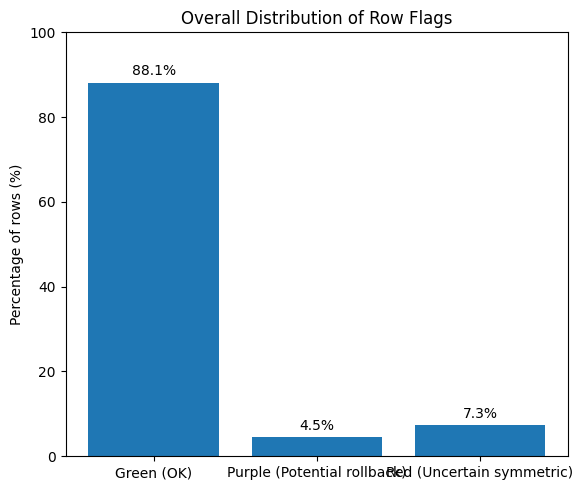

In [ ]:
# %% Overall percentages (Green / Purple / Red) and single chart
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Config ---
ROOT = '/content/drive/MyDrive/Winrate predictions'   # adjust if needed
ONLY_THROWS = False  # set True to only include throw rows

pattern = os.path.join(ROOT, '*_data_files', '*_with_ball_counts_v4.xlsx')
files = sorted(glob.glob(pattern))

if not files:
    raise FileNotFoundError(f"No output files found for pattern: {pattern}\nRun the processing step first.")

# --- Aggregate overall counts ---
totals = {'OK': 0, 'POTENTIAL_ROLLBACK': 0, 'UNCERTAIN_SYMMETRIC': 0}
overall_rows = 0

for fp in files:
    df = pd.read_excel(fp, sheet_name='events')
    if ONLY_THROWS and 'is_throw' in df.columns:
        df = df[df['is_throw'] == True]

    vc = df['review_flag'].value_counts(dropna=False).to_dict()
    totals['OK'] += int(vc.get('OK', 0))
    totals['POTENTIAL_ROLLBACK'] += int(vc.get('POTENTIAL_ROLLBACK', 0))
    totals['UNCERTAIN_SYMMETRIC'] += int(vc.get('UNCERTAIN_SYMMETRIC', 0))
    overall_rows += len(df)

if overall_rows == 0:
    raise ValueError("No rows counted. Check filters or inputs.")

overall_pct = {
    'Green (OK)': 100.0 * totals['OK'] / overall_rows,
    'Purple (Potential rollback)': 100.0 * totals['POTENTIAL_ROLLBACK'] / overall_rows,
    'Red (Uncertain symmetric)': 100.0 * totals['UNCERTAIN_SYMMETRIC'] / overall_rows
}

overall_df = pd.DataFrame([{
    'Category': k, 'Percentage': v, 'Count': totals['OK'] if 'Green' in k else totals['POTENTIAL_ROLLBACK'] if 'Purple' in k else totals['UNCERTAIN_SYMMETRIC']
} for k, v in overall_pct.items()])

# Save numeric summary
out_csv = os.path.join(ROOT, 'overall_row_color_percentages.csv')
overall_df.to_csv(out_csv, index=False)

# Display table
try:
    from caas_jupyter_tools import display_dataframe_to_user
    display_dataframe_to_user("Overall red/purple/green percentages", overall_df)
except Exception:
    pass

# --- Single bar chart (three bars) ---
labels = list(overall_pct.keys())
values = [overall_pct[k] for k in labels]

fig = plt.figure(figsize=(6, 5))
plt.bar(labels, values)
plt.ylabel('Percentage of rows (%)')
plt.title('Overall Distribution of Row Flags')
plt.ylim(0, 100)

# Annotate bars
for i, v in enumerate(values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', va='bottom')

plt.tight_layout()

# Save figure
out_png = os.path.join(ROOT, 'overall_row_color_percentages_bar.png')
plt.savefig(out_png, dpi=160, bbox_inches='tight')

print("Saved overall summary CSV:", out_csv)
print("Saved overall bar chart:", out_png)


In [ ]:
# %% =========================
# Colab / Imports
# ============================
import os, glob, re
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# %% =========================
# CONFIG
# ============================
ROOT = '/content/drive/MyDrive/Winrate predictions'  # <- change if needed
SAVE_DIR = ROOT
OUT_CSV = os.path.join(SAVE_DIR, "ball_rows_with_set_outcomes_SLIM.csv")

# Find every *_with_ball_counts_v4_SLIM.xlsx anywhere under ROOT
pattern_slim = os.path.join(ROOT, '**', '*_with_ball_counts_v4_SLIM.xlsx')
FILES = sorted(glob.glob(pattern_slim, recursive=True))
assert FILES, f"No SLIM files found for pattern: {pattern_slim}"
print(f"Found {len(FILES)} SLIM files")
for f in FILES[:5]: print("•", f)

# Options
DEDUP_WITHIN_SET = False   # True: keep one row per unique (team0_left,team1_left,ball_t0,ball_t1) per set
REQUIRE_ALL_FOUR = True    # Require all four features to be present
DEBUG_FIRST_N_FILES = 5    # 0 to silence per-file debug

# %% =========================
# Helpers
# ============================
def norm_col(s):
    return str(s).strip().lower().replace(" ", "_")

def is_set_end_point(row):
    dk = str(row.get("definitionkey","")).strip().lower()
    t  = str(row.get("title","")).strip().lower()
    return (dk in {"point_win","point_lose"}) or (t in {"point_win","point_lose"})

def outcome_from_set_end(last_row):
    dk = str(last_row.get("definitionkey","")).strip().lower()
    t  = str(last_row.get("title","")).strip().lower()
    key = dk if dk in {"point_win","point_lose"} else t
    if key == "point_win":  return 1   # team0 wins
    if key == "point_lose": return 0   # team1 wins
    return np.nan

def load_and_standardize_xlsx(path):
    df = pd.read_excel(path)
    df.columns = [norm_col(c) for c in df.columns]
    # Harmonize common variants
    rename_map = {
        "team_0_left": "team0_left",
        "team_1_left": "team1_left",
        "ball__t1": "ball_t1",   # occasional typo guard
    }
    for k,v in rename_map.items():
        if k in df.columns:
            df = df.rename(columns={k:v})
    # Types
    for c in ["team0_left","team1_left","ball_t0","ball_t1","time","eventid","team"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    # Order within file
    sort_cols = [c for c in ["reviewid","eventid","time"] if c in df.columns]
    if sort_cols:
        df = df.sort_values(sort_cols).reset_index(drop=True)
    else:
        df = df.reset_index(drop=True)
    return df

def add_set_index(df):
    """
    Create set_id that increments AFTER each end row, but keeps the end row in its set:
    set_id = cumsum(end_flag) - end_flag
    """
    if "reviewid" not in df.columns:
        df["reviewid"] = "unknown"
    end_flag = df.apply(is_set_end_point, axis=1).astype(int)
    df["set_end_flag"] = end_flag
    df["cumsum_end"]   = df.groupby("reviewid")["set_end_flag"].cumsum()
    df["set_id"]       = (df["cumsum_end"] - df["set_end_flag"]).astype(int)
    return df

# %% =========================
# Build dataset: keep ALL rows with ball counts, label with set outcome
# ============================
all_rows = []
kept_per_file = []

for i, fp in enumerate(FILES, 1):
    try:
        df = load_and_standardize_xlsx(fp)
        if not {"definitionkey","title"}.issubset(df.columns):
            print(f"[Skip] Missing cols in {os.path.basename(fp)}")
            continue

        df = add_set_index(df)

        if i <= DEBUG_FIRST_N_FILES:
            ends = df.apply(is_set_end_point, axis=1).sum()
            print(f"[DEBUG] {os.path.basename(fp)} | rows={len(df)} | end_rows={ends} | sets={df['set_id'].nunique()}")

        before_ct = after_ct = 0

        for (rid, sid), g in df.groupby(["reviewid","set_id"], sort=False):
            # Need a proper end row
            last_row = g.iloc[-1]
            if not is_set_end_point(last_row):
                continue
            outcome = outcome_from_set_end(last_row)
            if np.isnan(outcome):
                continue

            # Keep rows with ball counts (and team counts if required)
            rows = g.copy()
            if REQUIRE_ALL_FOUR:
                mask = (
                    rows["ball_t0"].notna() &
                    rows["ball_t1"].notna() &
                    rows["team0_left"].notna() &
                    rows["team1_left"].notna()
                )
            else:
                mask = rows["ball_t0"].notna() & rows["ball_t1"].notna()
            rows = rows[mask]
            if rows.empty:
                continue

            before_ct += len(rows)

            if DEDUP_WITHIN_SET:
                rows = rows.drop_duplicates(subset=["team0_left","team1_left","ball_t0","ball_t1"])

            rows = rows[["reviewid","set_id","time","team0_left","team1_left","ball_t0","ball_t1","team"]]
            rows = rows.rename(columns={"time":"time_at_row"})
            rows["set_outcome_team0_win"] = outcome
            rows["source_file"] = os.path.basename(fp)

            all_rows.append(rows)
            after_ct += len(rows)

        kept_per_file.append((os.path.basename(fp), before_ct, after_ct))

        if i <= DEBUG_FIRST_N_FILES:
            print(f"[DEBUG] kept rows (before->after dedup) = {before_ct} -> {after_ct}")

    except Exception as e:
        print(f"[Error] {os.path.basename(fp)} -> {repr(e)}")

if not all_rows:
    raise RuntimeError("No qualifying rows found. Ensure columns exist and end rows are 'point_win'/'point_lose'.")

ball_df = pd.concat(all_rows, ignore_index=True)
print("Total rows kept:", len(ball_df))
print("Per-file kept (first 10):")
for name, b, a in kept_per_file[:10]:
    print(f"  {name}: {b} -> {a}")

# Save raw dataset
ball_df.to_csv(OUT_CSV, index=False)
print("Saved dataset ->", OUT_CSV)

# %% =========================
# BASIC (non-symmetric) summaries
# ============================
def win_rate_by(df, col):
    tmp = (
        df.groupby(col)["set_outcome_team0_win"]
          .agg(["mean","count"])
          .rename(columns={"mean":"win_rate_team0","count":"rows"})
          .reset_index().sort_values(col)
    )
    return tmp

print("\nRaw (team0 vs team1) win rate tables:")
print(win_rate_by(ball_df, "team0_left").head(30))
print(win_rate_by(ball_df, "team1_left").head(30))
print(win_rate_by(ball_df, "ball_t0").head(30))
print(win_rate_by(ball_df, "ball_t1").head(30))

players_matrix_raw = ball_df.pivot_table(
    index="team0_left", columns="team1_left",
    values="set_outcome_team0_win", aggfunc="mean"
).sort_index().sort_index(axis=1)
print("\nRaw matrix team0_left x team1_left:\n", players_matrix_raw)

# %% =========================
# TEAM-AGNOSTIC (MIRRORED) ANALYSIS
# Make the advantaged side always team0, and flip label accordingly
# ============================
canon = ball_df.copy()

swap_mask = (
    (canon["team0_left"] < canon["team1_left"]) |
    ((canon["team0_left"] == canon["team1_left"]) & (canon["ball_t0"] < canon["ball_t1"]))
)

t0_players = canon.loc[swap_mask, "team0_left"].copy()
t0_balls   = canon.loc[swap_mask, "ball_t0"].copy()

canon.loc[swap_mask, "team0_left"] = canon.loc[swap_mask, "team1_left"].values
canon.loc[swap_mask, "team1_left"] = t0_players.values
canon.loc[swap_mask, "ball_t0"]    = canon.loc[swap_mask, "ball_t1"].values
canon.loc[swap_mask, "ball_t1"]    = t0_balls.values
canon.loc[swap_mask, "set_outcome_team0_win"] = 1 - canon.loc[swap_mask, "set_outcome_team0_win"]

print(f"\nSymmetry swap applied to {swap_mask.sum()} rows.")

# Advantages (now team0 is the advantaged side by players; ball_advantage can be +/-)
canon["player_advantage"] = canon["team0_left"] - canon["team1_left"]   # >= 0 by design
canon["ball_advantage"]   = canon["ball_t0"]    - canon["ball_t1"]      # may be negative / positive / zero

# Symmetric matrices / summaries
players_matrix = canon.pivot_table(
    index="team0_left", columns="team1_left",
    values="set_outcome_team0_win", aggfunc="mean"
).sort_index().sort_index(axis=1)
print("\nSymmetric matrix (rows=hi players, cols=lo players):\n", players_matrix)

adv_matrix = canon.pivot_table(
    index="player_advantage", columns="ball_advantage",
    values="set_outcome_team0_win", aggfunc="mean"
).sort_index().sort_index(axis=1)
print("\nMatrix (player_advantage x ball_advantage) — P(advantaged side wins):\n", adv_matrix)

wr_ball_only = (
    canon.groupby("ball_advantage")["set_outcome_team0_win"]
         .agg(["mean","count"])
         .rename(columns={"mean":"win_rate_adv_side","count":"rows"})
         .reset_index().sort_values("ball_advantage")
)
print("\nWin rate by ball_advantage (adv side perspective):\n", wr_ball_only)

# %% =========================
# Logistic regression
# 1) Raw orientation (team0/team1 as-is)
# 2) Symmetric orientation using advantages
# ============================
def fit_logit(X, y, feature_names):
    pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("clf", LogisticRegression(max_iter=2000))
    ])
    pipe.fit(X, y)
    coefs = pd.Series(pipe.named_steps["clf"].coef_[0], index=feature_names, name="logit_coef")
    return coefs

# (1) Raw
raw_model_df = ball_df[["team0_left","team1_left","ball_t0","ball_t1","set_outcome_team0_win"]].dropna().copy()
X_raw = raw_model_df[["team0_left","team1_left","ball_t0","ball_t1"]].astype(float)
y_raw = raw_model_df["set_outcome_team0_win"].astype(int)
try:
    coefs_raw = fit_logit(X_raw, y_raw, X_raw.columns)
    print("\nLogistic coefficients (RAW, scaled):\n", coefs_raw.sort_values(ascending=False))
except Exception as e:
    print("\n[WARN] Raw logistic fit skipped:", e)

# (2) Symmetric (advantages)
sym_model_df = canon[["player_advantage","ball_advantage","set_outcome_team0_win"]].dropna().copy()
X_sym = sym_model_df[["player_advantage","ball_advantage"]].astype(float)
y_sym = sym_model_df["set_outcome_team0_win"].astype(int)
try:
    coefs_sym = fit_logit(X_sym, y_sym, X_sym.columns)
    print("\nLogistic coefficients (SYMMETRIC, scaled):\n", coefs_sym.sort_values(ascending=False))
except Exception as e:
    print("\n[WARN] Symmetric logistic fit skipped:", e)


Found 58 SLIM files
• /content/drive/MyDrive/Winrate predictions/01d7c3a8-0625-4e71-adc1-6420cc0f5390_data_files/01d7c3a8-0625-4e71-adc1-6420cc0f5390_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx
• /content/drive/MyDrive/Winrate predictions/06b6f8fa-6d72-4d07-aa6f-9ed59bb93c98_data_files/06b6f8fa-6d72-4d07-aa6f-9ed59bb93c98_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx
• /content/drive/MyDrive/Winrate predictions/0e175f77-448e-43f0-bf41-7db72a16a8b9_data_files/0e175f77-448e-43f0-bf41-7db72a16a8b9_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx
• /content/drive/MyDrive/Winrate predictions/156b984e-956f-40b1-a1f6-06e955fd7ace_data_files/156b984e-956f-40b1-a1f6-06e955fd7ace_events_with_phase1_tags_by_nearest_time_with_ball_counts_v4_SLIM.xlsx
• /content/drive/MyDrive/Winrate predictions/20b66b9a-d853-4687-b955-f9e96ce40330_data_files/20b66b9a-d853-4687-b955-f9e96ce40330_events_with_phase1_tags_by_nearest_time_with_ball_

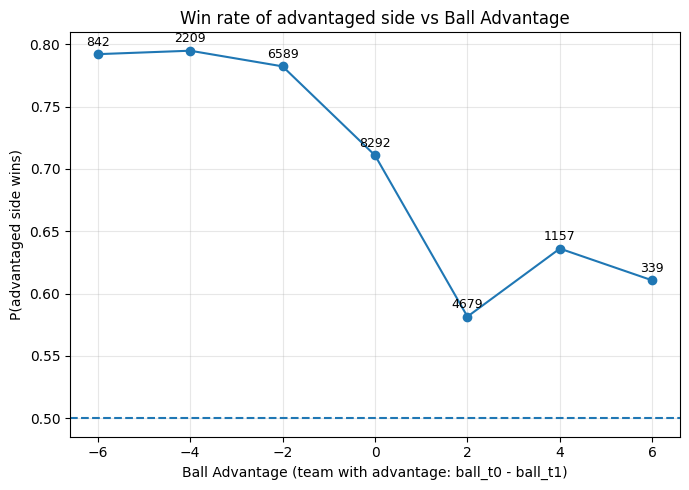

Saved: /content/drive/MyDrive/Winrate predictions/plot_winrate_vs_ball_advantage.png


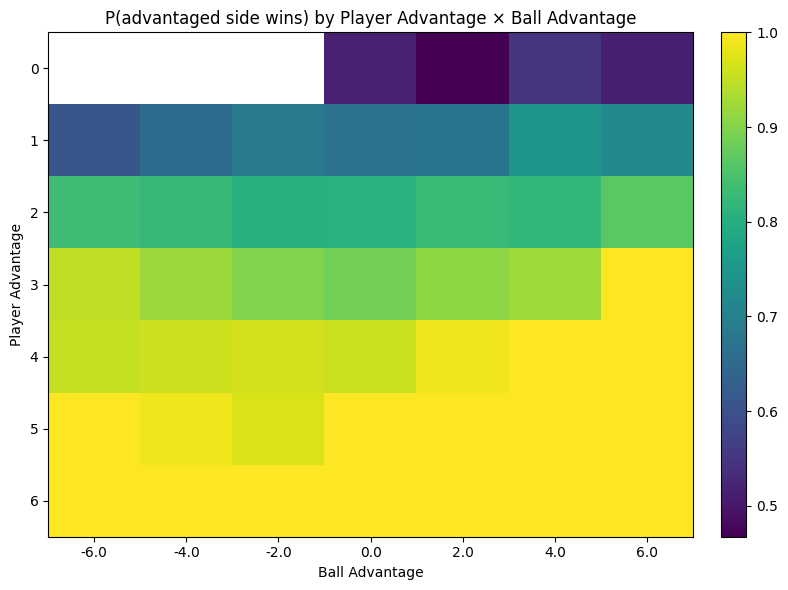

Saved: /content/drive/MyDrive/Winrate predictions/heatmap_winrate_advantage_matrix.png


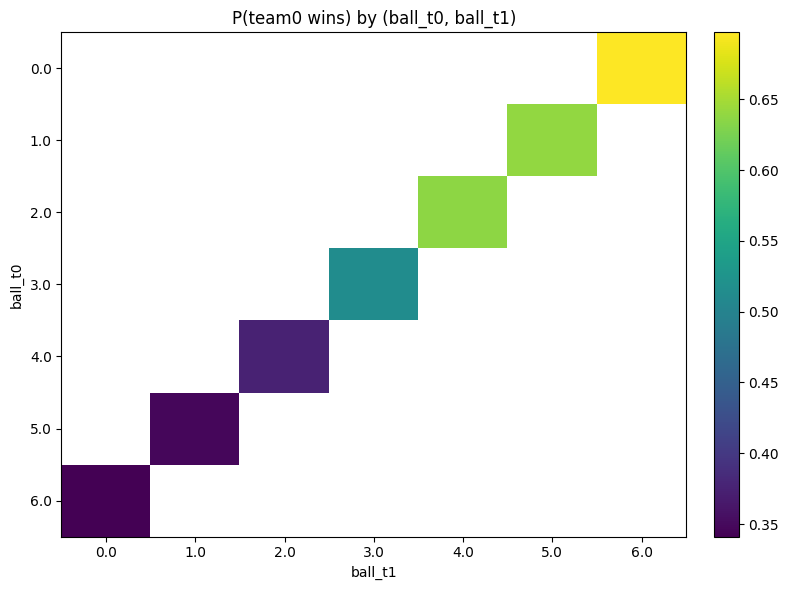

Saved: /content/drive/MyDrive/Winrate predictions/heatmap_winrate_raw_ball_counts.png


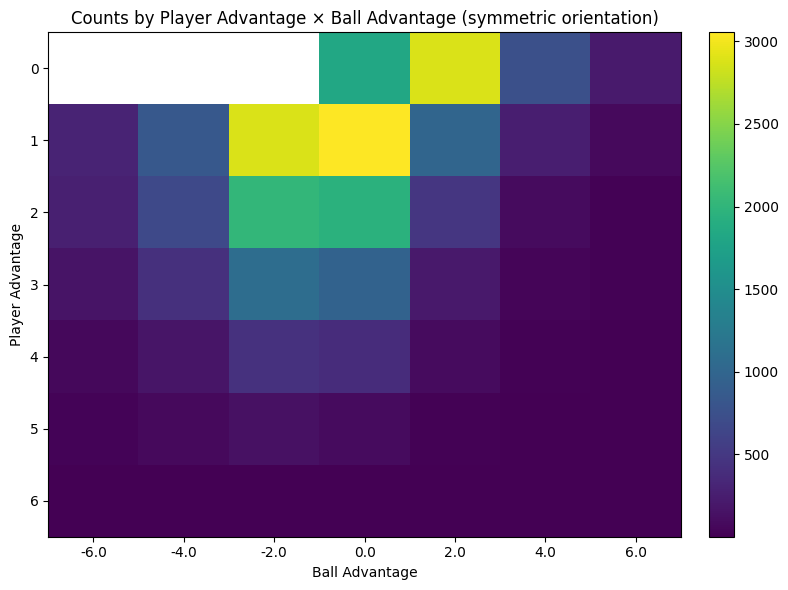

Saved: /content/drive/MyDrive/Winrate predictions/heatmap_counts_advantage_matrix.png


In [ ]:
# %% =========================
# PLOTS: Ball counts & advantages impact
# Requirements: variables `ball_df`, `canon`, and `SAVE_DIR` exist from previous cell
# `canon` = mirrored orientation (advantaged side as team0)
# ============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# ---------- 1) Line: P(adv side wins) vs Ball Advantage ----------
min_rows = 20  # hide very sparse buckets

ball_adv = (
    canon.groupby("ball_advantage")["set_outcome_team0_win"]
         .agg(["mean", "count"])
         .rename(columns={"mean": "win_rate_adv_side"})
         .reset_index()
         .sort_values("ball_advantage")
)

ball_adv_filtered = ball_adv[ball_adv["count"] >= min_rows]

plt.figure(figsize=(7, 5))
plt.plot(ball_adv_filtered["ball_advantage"], ball_adv_filtered["win_rate_adv_side"], marker="o")
for _, r in ball_adv_filtered.iterrows():
    plt.annotate(int(r["count"]), (r["ball_advantage"], r["win_rate_adv_side"]), xytext=(0, 6), textcoords="offset points", ha="center", fontsize=9)
plt.axhline(0.5, linestyle="--")
plt.title("Win rate of advantaged side vs Ball Advantage")
plt.xlabel("Ball Advantage (team with advantage: ball_t0 - ball_t1)")
plt.ylabel("P(advantaged side wins)")
plt.grid(True, alpha=0.3)
fig1_path = os.path.join(SAVE_DIR, "plot_winrate_vs_ball_advantage.png")
plt.tight_layout()
plt.savefig(fig1_path, dpi=150)
plt.show()
print("Saved:", fig1_path)

# ---------- 2) Heatmap: P(adv side wins) by (Player Advantage, Ball Advantage) ----------
heat = (
    canon.groupby(["player_advantage", "ball_advantage"])["set_outcome_team0_win"]
         .mean()
         .unstack("ball_advantage")
         .sort_index(axis=0).sort_index(axis=1)
)

plt.figure(figsize=(8, 6))
im = plt.imshow(heat.values, aspect="auto", interpolation="nearest")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("P(advantaged side wins) by Player Advantage × Ball Advantage")
plt.xlabel("Ball Advantage")
plt.ylabel("Player Advantage")

# ticks
xvals = list(heat.columns)
yvals = list(heat.index)
plt.xticks(ticks=np.arange(len(xvals)), labels=xvals)
plt.yticks(ticks=np.arange(len(yvals)), labels=yvals)

plt.tight_layout()
fig2_path = os.path.join(SAVE_DIR, "heatmap_winrate_advantage_matrix.png")
plt.savefig(fig2_path, dpi=150)
plt.show()
print("Saved:", fig2_path)

# ---------- 3) Heatmap: Raw orientation — P(team0 wins) by (ball_t0, ball_t1) ----------
raw_ball = (
    ball_df.pivot_table(index="ball_t0", columns="ball_t1",
                        values="set_outcome_team0_win", aggfunc="mean")
            .sort_index().sort_index(axis=1)
)

plt.figure(figsize=(8, 6))
im2 = plt.imshow(raw_ball.values, aspect="auto", interpolation="nearest")
plt.colorbar(im2, fraction=0.046, pad=0.04)
plt.title("P(team0 wins) by (ball_t0, ball_t1)")
plt.xlabel("ball_t1")
plt.ylabel("ball_t0")
plt.xticks(ticks=np.arange(len(raw_ball.columns)), labels=list(raw_ball.columns))
plt.yticks(ticks=np.arange(len(raw_ball.index)),   labels=list(raw_ball.index))
plt.tight_layout()
fig3_path = os.path.join(SAVE_DIR, "heatmap_winrate_raw_ball_counts.png")
plt.savefig(fig3_path, dpi=150)
plt.show()
print("Saved:", fig3_path)

# ---------- 4) (Optional) Heatmap: counts behind the symmetric matrix ----------
count_mat = (
    canon.groupby(["player_advantage", "ball_advantage"])["set_outcome_team0_win"]
         .count()
         .unstack("ball_advantage")
         .sort_index(axis=0).sort_index(axis=1)
)

plt.figure(figsize=(8, 6))
im3 = plt.imshow(count_mat.values, aspect="auto", interpolation="nearest")
plt.colorbar(im3, fraction=0.046, pad=0.04)
plt.title("Counts by Player Advantage × Ball Advantage (symmetric orientation)")
plt.xlabel("Ball Advantage")
plt.ylabel("Player Advantage")
plt.xticks(ticks=np.arange(len(count_mat.columns)), labels=list(count_mat.columns))
plt.yticks(ticks=np.arange(len(count_mat.index)),   labels=list(count_mat.index))
plt.tight_layout()
fig4_path = os.path.join(SAVE_DIR, "heatmap_counts_advantage_matrix.png")
plt.savefig(fig4_path, dpi=150)
plt.show()
print("Saved:", fig4_path)


In [ ]:
# %% =========================
# NEXT-KILL (one-previous-row) ANALYSIS
# ============================
import numpy as np
import pandas as pd
import os

assert 'ball_df' in globals(), "ball_df not found. Run the earlier build cell first."

def rows_from_prev_state(group):
    """
    For one (reviewid,set_id) group (sorted), produce ONE observation per kill:
      - read state at k-1 (prev row)
      - determine winner at k
      - label if ball-adv side at k-1 got the kill
    Skips double-kills (both teams decrease at k) and rows with missing ball counts.
    """
    g = group.reset_index(drop=True).copy()
    n = len(g)
    if n < 2:
        return []

    t0 = g["team0_left"].to_numpy()
    t1 = g["team1_left"].to_numpy()

    # kill occurs at row k if counts drop vs previous row (k-1)
    kill_by_team1 = np.r_[False, t0[1:] < t0[:-1]]  # team0 decreased => killer is team1
    kill_by_team0 = np.r_[False, t1[1:] < t1[:-1]]  # team1 decreased => killer is team0
    kill_any = kill_by_team0 | kill_by_team1
    k_ids = np.flatnonzero(kill_any)  # k >= 1

    out = []
    for k in k_ids:
        # skip double-kill rows
        if kill_by_team0[k] and kill_by_team1[k]:
            continue

        i = k - 1  # use exactly one previous row
        b0 = g.at[i, "ball_t0"]; b1 = g.at[i, "ball_t1"]
        if pd.isna(b0) or pd.isna(b1):
            continue

        # winner at k
        winner = "team0" if kill_by_team0[k] else "team1"

        # ball-advantaged side at k-1
        if b0 > b1:
            adv_side = "team0"
            next_by_adv = 1 if winner == "team0" else 0
        elif b1 > b0:
            adv_side = "team1"
            next_by_adv = 1 if winner == "team1" else 0
        else:
            adv_side = "tie"
            next_by_adv = np.nan  # no ball advantage at i

        rec = {
            "reviewid": g.at[i, "reviewid"],
            "set_id":   g.at[i, "set_id"],
            "pre_idx":  i,
            "kill_idx": k,
            "ball_t0_prev": int(b0),
            "ball_t1_prev": int(b1),
            "team0_left_prev": int(g.at[i, "team0_left"]),
            "team1_left_prev": int(g.at[i, "team1_left"]),
            "player_adv_prev": int(g.at[i, "team0_left"] - g.at[i, "team1_left"]),
            "ball_adv_prev":   int(b0 - b1),
            "winner_at_k": winner,
            "adv_side_prev": adv_side,
            "next_kill_by_adv": next_by_adv,               # NaN for ties
            "next_kill_by_team0": 1 if winner == "team0" else 0,
            "source_file": g.at[i, "source_file"] if "source_file" in g.columns else None,
        }
        # optional time delta if present
        tcol = "time_at_row" if "time_at_row" in g.columns else None
        if tcol:
            try:
                rec["dt_to_kill"] = float(g.at[k, tcol] - g.at[i, tcol])
            except Exception:
                rec["dt_to_kill"] = np.nan

        out.append(rec)

    return out

# Build dataset: one row per kill, using the immediately previous state
rows = []
for (rid, sid), grp in ball_df.groupby(["reviewid", "set_id"], sort=False):
    rows.extend(rows_from_prev_state(grp))

nk_prev = pd.DataFrame(rows)
print("Observations (one per kill):", len(nk_prev))
if nk_prev.empty:
    raise RuntimeError("No kills detected. Verify team*_left decreases exist.")

# ---------- A) Prob by exact ball pair at k-1 (team0, team1) ----------
prob_pair_team0 = (
    nk_prev.groupby(["ball_t0_prev","ball_t1_prev"])["next_kill_by_team0"]
           .agg(["mean","count"])
           .rename(columns={"mean":"p_next_kill_by_team0"})
           .reset_index()
           .sort_values(["ball_t0_prev","ball_t1_prev"])
)
print("\nP(team0 gets next kill) by (ball_t0_prev, ball_t1_prev):")
print(prob_pair_team0.head(20))

# ---------- B) Prob that ball-ADV side gets next kill by exact pair (exclude ties) ----------
adv_rows = nk_prev.dropna(subset=["next_kill_by_adv"]).copy()
prob_pair_adv = (
    adv_rows.groupby(["ball_t0_prev","ball_t1_prev"])["next_kill_by_adv"]
            .agg(["mean","count"])
            .rename(columns={"mean":"p_next_kill_by_adv"})
            .reset_index()
            .sort_values(["ball_t0_prev","ball_t1_prev"])
)
print("\nP(next kill by ball-adv side) by (ball_t0_prev, ball_t1_prev) [ties excluded]:")
print(prob_pair_adv.head(20))

# ---------- C) Symmetric view: collapse (a,b) and (b,a) to (hi,lo) ----------
sym = adv_rows.copy()
sym["hi_ball"] = sym[["ball_t0_prev","ball_t1_prev"]].max(axis=1).astype(int)
sym["lo_ball"] = sym[["ball_t0_prev","ball_t1_prev"]].min(axis=1).astype(int)

prob_pair_adv_sym = (
    sym.groupby(["hi_ball","lo_ball"])["next_kill_by_adv"]
       .agg(["mean","count"])
       .rename(columns={"mean":"p_next_kill_by_adv"})
       .reset_index()
       .sort_values(["hi_ball","lo_ball"])
)
print("\nSYMMETRIC P(next kill by ball-adv side) by (hi_ball, lo_ball):")
print(prob_pair_adv_sym.head(20))

# ---------- D) Also by |ball advantage| magnitude ----------
sym["abs_ball_adv"] = (sym["hi_ball"] - sym["lo_ball"]).astype(int)
prob_by_abs = (
    sym.groupby("abs_ball_adv")["next_kill_by_adv"]
       .agg(["mean","count"])
       .rename(columns={"mean":"p_next_kill_by_adv"})
       .reset_index()
       .sort_values("abs_ball_adv")
)
print("\nP(next kill by ball-adv side) vs |ball advantage| (prev row):")
print(prob_by_abs)

# Save CSVs
SAVE_DIR = SAVE_DIR if 'SAVE_DIR' in globals() else '.'
outA = os.path.join(SAVE_DIR, "next_kill_prev_state_prob_team0_by_pair.csv")
outB = os.path.join(SAVE_DIR, "next_kill_prev_state_prob_adv_by_pair.csv")
outC = os.path.join(SAVE_DIR, "next_kill_prev_state_prob_adv_by_pair_SYM.csv")
outD = os.path.join(SAVE_DIR, "next_kill_prev_state_prob_adv_by_abs_adv.csv")
prob_pair_team0.to_csv(outA, index=False)
prob_pair_adv.to_csv(outB, index=False)
prob_pair_adv_sym.to_csv(outC, index=False)
prob_by_abs.to_csv(outD, index=False)
print("\nSaved:")
print(" -", outA)
print(" -", outB)
print(" -", outC)
print(" -", outD)


Observations (one per kill): 5967

P(team0 gets next kill) by (ball_t0_prev, ball_t1_prev):
   ball_t0_prev  ball_t1_prev  p_next_kill_by_team0  count
0             0             6              0.953488     86
1             1             5              0.710594    387
2             2             4              0.753138   1434
3             3             3              0.512416   2094
4             4             2              0.260544   1470
5             5             1              0.315000    400
6             6             0              0.145833     96

P(next kill by ball-adv side) by (ball_t0_prev, ball_t1_prev) [ties excluded]:
   ball_t0_prev  ball_t1_prev  p_next_kill_by_adv  count
0             0             6            0.046512     86
1             1             5            0.289406    387
2             2             4            0.246862   1434
3             4             2            0.260544   1470
4             5             1            0.315000    400
5             

In [ ]:
# %% =========================
# Install + imports
# ============================
!pip -q install xgboost==2.0.3

import os, glob
import numpy as np
import pandas as pd

from sklearn.metrics import (
    roc_auc_score, average_precision_score, log_loss,
    brier_score_loss, accuracy_score
)
import xgboost as xgb
from xgboost.callback import EarlyStopping

# %% =========================
# CONFIG
# ============================
ROOT = "/content/drive/MyDrive/Winrate predictions"   # <-- change if needed
PATTERN = os.path.join(ROOT, "**", "*_with_ball_counts_v4_SLIM.xlsx")
OUT_DIR = ROOT

MODEL_PATH = os.path.join(OUT_DIR, "xgb_set_win_model_mirrored.json")
PRED_PATH  = os.path.join(OUT_DIR, "xgb_predictions_mirrored.csv")
DATA_PATH  = os.path.join(OUT_DIR, "xgb_training_rows_mirrored.csv")

MIRROR_AUGMENT = True        # <-- duplicates each row with teams swapped + label flipped
DEDUP_WITHIN_SET = False     # optional

# IMPORTANT: keep CANONICALIZE_ADV = False when MIRROR_AUGMENT = True
CANONICALIZE_ADV = False

# %% =========================
# Helpers
# ============================
def norm_col(s): return str(s).strip().lower().replace(" ", "_")

def is_end(row):
    dk = str(row.get("definitionkey","")).strip().lower()
    t  = str(row.get("title","")).strip().lower()
    return (dk in {"point_win","point_lose"}) or (t in {"point_win","point_lose"})

def outcome_from_end(last_row):
    dk = str(last_row.get("definitionkey","")).strip().lower()
    t  = str(last_row.get("title","")).strip().lower()
    key = dk if dk in {"point_win","point_lose"} else t
    if key == "point_win":  return 1  # team0 wins the set
    if key == "point_lose": return 0  # team1 wins the set
    return np.nan

def load_file(fp):
    df = pd.read_excel(fp)
    df.columns = [norm_col(c) for c in df.columns]
    df = df.rename(columns={"team_0_left":"team0_left","team_1_left":"team1_left","ball__t1":"ball_t1"})
    for c in ["team0_left","team1_left","ball_t0","ball_t1","time","eventid","team"]:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    sort_cols = [c for c in ["reviewid","eventid","time"] if c in df.columns]
    if sort_cols: df = df.sort_values(sort_cols).reset_index(drop=True)
    else:         df = df.reset_index(drop=True)
    return df

def add_set_id(df):
    if "reviewid" not in df.columns: df["reviewid"] = "unknown"
    end_flag = df.apply(is_end, axis=1).astype(int)
    df["set_end_flag"] = end_flag
    df["cumsum_end"]   = df.groupby("reviewid")["set_end_flag"].cumsum()
    df["set_id"]       = (df["cumsum_end"] - df["set_end_flag"]).astype(int)  # keep end row in its set
    return df

# %% =========================
# Build dataset (label = final set outcome; many rows per set)
# ============================
files = sorted(glob.glob(PATTERN, recursive=True))
assert files, f"No files found for {PATTERN}"
print(f"Found {len(files)} SLIM files")

rows = []
for fp in files:
    try:
        df = load_file(fp)
        needed = {"definitionkey","title","ball_t0","ball_t1","team0_left","team1_left"}
        if not needed.issubset(df.columns):
            print("[Skip] missing required cols in", os.path.basename(fp))
            continue

        df = add_set_id(df)

        for (rid, sid), g in df.groupby(["reviewid","set_id"], sort=False):
            last = g.iloc[-1]
            if not is_end(last): continue
            y = outcome_from_end(last)
            if np.isnan(y): continue

            mask = (
                g["ball_t0"].notna() & g["ball_t1"].notna() &
                g["team0_left"].notna() & g["team1_left"].notna()
            )
            gg = g.loc[mask, ["reviewid","set_id","team0_left","team1_left","ball_t0","ball_t1"]].copy()
            if gg.empty: continue

            if DEDUP_WITHIN_SET:
                gg = gg.drop_duplicates(subset=["team0_left","team1_left","ball_t0","ball_t1"])

            gg["set_outcome_team0_win"] = int(y)
            gg["set_key"] = gg["reviewid"].astype(str) + "_" + gg["set_id"].astype(str)
            rows.append(gg)
    except Exception as e:
        print("[Error]", os.path.basename(fp), "->", e)

data = pd.concat(rows, ignore_index=True)
print("Raw rows:", len(data), "| sets:", data["set_key"].nunique())

# ---- Enforce total balls == 6 (drop anything else)
sum_balls = (data["ball_t0"].round().astype(int) + data["ball_t1"].round().astype(int))
keep_mask = (sum_balls == 6)
dropped = len(data) - keep_mask.sum()
if dropped:
    print(f"Filtered rows with total balls != 6: {dropped}")
data = data[keep_mask].copy()

# ---- Optional canonicalization (DISABLE if mirroring)
if CANONICALIZE_ADV:
    swap = (
        (data["team0_left"] < data["team1_left"]) |
        ((data["team0_left"] == data["team1_left"]) & (data["ball_t0"] < data["ball_t1"]))
    )
    t0p = data.loc[swap, "team0_left"].copy()
    t0b = data.loc[swap, "ball_t0"].copy()
    data.loc[swap, "team0_left"] = data.loc[swap, "team1_left"].values
    data.loc[swap, "team1_left"] = t0p.values
    data.loc[swap, "ball_t0"]    = data.loc[swap, "ball_t1"].values
    data.loc[swap, "ball_t1"]    = t0b.values
    data.loc[swap, "set_outcome_team0_win"] = 1 - data.loc[swap, "set_outcome_team0_win"]

# ---- MIRROR AUGMENTATION (kills team0/team1 bias)
if MIRROR_AUGMENT:
    mir = data.copy()
    mir["team0_left"], mir["team1_left"] = data["team1_left"].values, data["team0_left"].values
    mir["ball_t0"],   mir["ball_t1"]     = data["ball_t1"].values,   data["ball_t0"].values
    mir["set_outcome_team0_win"]         = 1 - data["set_outcome_team0_win"].values
    mir["is_mirrored"] = 1
    data["is_mirrored"] = 0
    data = pd.concat([data, mir], ignore_index=True)
    print("After mirroring, rows:", len(data))

# ---- Features (drop total_balls; it’s always 6)
data["player_advantage"] = data["team0_left"] - data["team1_left"]
data["ball_advantage"]   = data["ball_t0"]    - data["ball_t1"]
data["total_players"]    = data["team0_left"] + data["team1_left"]

FEATURES = [
    "team0_left","team1_left","ball_t0","ball_t1",
    "player_advantage","ball_advantage","total_players"
]
TARGET = "set_outcome_team0_win"

# Save the assembled dataset (optional)
data.to_csv(DATA_PATH, index=False)
print("Saved training rows ->", DATA_PATH)

# %% =========================
# Grouped train/val/test split by SET (no leakage)
# ============================
rng = np.random.RandomState(42)
sets = data["set_key"].unique()
rng.shuffle(sets)
n = len(sets); n_train = int(0.7*n); n_val = int(0.15*n)
train_sets = set(sets[:n_train])
val_sets   = set(sets[n_train:n_train+n_val])
test_sets  = set(sets[n_train+n_val:])

train = data[data["set_key"].isin(train_sets)]
val   = data[data["set_key"].isin(val_sets)]
test  = data[data["set_key"].isin(test_sets)]

X_train, y_train = train[FEATURES].values, train[TARGET].values
X_val,   y_val   = val[FEATURES].values,   val[TARGET].values
X_test,  y_test  = test[FEATURES].values,  test[TARGET].values

print("Sets -> train/val/test:", len(train_sets), len(val_sets), len(test_sets))
print("Rows -> train/val/test:", len(train), len(val), len(test))

# Class imbalance weight (optional)
pos = (y_train == 1).sum(); neg = (y_train == 0).sum()
scale_pos_weight = float(neg) / float(max(pos,1))
print("scale_pos_weight:", round(scale_pos_weight, 3))

# %% =========================
# Train XGBoost (binary:logistic) with EarlyStopping
# ============================
clf = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    reg_alpha=0.0,
    tree_method="hist",
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric="logloss",
)
callbacks = [EarlyStopping(rounds=100, save_best=True, maximize=False)]
clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    callbacks=callbacks,
    verbose=50,
)

# %% =========================
# Evaluation (no eps kwarg)
# ============================
def eval_block(name, y_true, proba):
    proba = np.clip(proba, 1e-7, 1 - 1e-7)
    auc = roc_auc_score(y_true, proba)
    ap  = average_precision_score(y_true, proba)
    ll  = log_loss(y_true, proba)
    br  = brier_score_loss(y_true, proba)
    acc = accuracy_score(y_true, (proba >= 0.5).astype(int))
    print(f"{name}: AUC={auc:.4f}  AP={ap:.4f}  LogLoss={ll:.4f}  Brier={br:.4f}  Acc@0.5={acc:.4f}")

p_tr = clf.predict_proba(X_train)[:,1]
p_va = clf.predict_proba(X_val)[:,1]
p_te = clf.predict_proba(X_test)[:,1]

eval_block("TRAIN", y_train, p_tr)
eval_block("VAL  ", y_val,   p_va)
eval_block("TEST ", y_test,  p_te)

# Save model + test predictions
clf.save_model(MODEL_PATH)
pred_df = test[["reviewid","set_id"] + FEATURES].copy()
pred_df["y_true"] = y_test
pred_df["p_team0_win"] = p_te
pred_df.to_csv(PRED_PATH, index=False)
print("Saved model ->", MODEL_PATH)
print("Saved predictions ->", PRED_PATH)

# %% =========================
# Feature importance (gain)
# ============================
imp = pd.Series(clf.get_booster().get_score(importance_type="gain"))
imp.index = [int(k[1:]) for k in imp.index]  # f0, f1...
imp = imp.sort_values(ascending=False)
feature_map = {i:f for i,f in enumerate(FEATURES)}
imp_named = imp.rename(index=feature_map)
print("\nFeature importance (gain):")
print(imp_named.head(20))

# %% =========================
# Example prediction
# ============================
example = pd.DataFrame([{
    "team0_left":3, "team1_left":3, "ball_t0":6, "ball_t1":0,
    "player_advantage":3-3, "ball_advantage":0,
    "total_players":3+3
}])[FEATURES]
prob = clf.predict_proba(example)[:,1][0]
print(f"\nP(team0 wins set) for example state = {prob:.3f}")


Found 58 SLIM files
Raw rows: 24107 | sets: 761
After mirroring, rows: 48214
Saved training rows -> /content/drive/MyDrive/Winrate predictions/xgb_training_rows_mirrored.csv
Sets -> train/val/test: 532 114 115
Rows -> train/val/test: 33474 7194 7546
scale_pos_weight: 1.0
[0]	validation_0-logloss:0.68043	validation_1-logloss:0.67960
[50]	validation_0-logloss:0.54346	validation_1-logloss:0.52491


/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.53915	validation_1-logloss:0.51970
[150]	validation_0-logloss:0.53791	validation_1-logloss:0.51967
[200]	validation_0-logloss:0.53714	validation_1-logloss:0.52029
[232]	validation_0-logloss:0.53679	validation_1-logloss:0.52051
TRAIN: AUC=0.7975  AP=0.7972  LogLoss=0.5382  Brier=0.1830  Acc@0.5=0.7142
VAL  : AUC=0.8187  AP=0.8167  LogLoss=0.5195  Brier=0.1740  Acc@0.5=0.7259
TEST : AUC=0.8000  AP=0.7912  LogLoss=0.5464  Brier=0.1822  Acc@0.5=0.7285
Saved model -> /content/drive/MyDrive/Winrate predictions/xgb_set_win_model_mirrored.json
Saved predictions -> /content/drive/MyDrive/Winrate predictions/xgb_predictions_mirrored.csv

Feature importance (gain):
player_advantage    151.661957
team1_left           27.692110
team0_left           24.025263
total_players         3.241121
ball_t0               3.015359
ball_t1               2.806956
dtype: float64

P(team0 wins set) for example state = 0.563


In [ ]:
# %% =========================
# Try alternative models (+ optional calibration & LightGBM/CatBoost)
# ============================
import numpy as np
import pandas as pd
import os, joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss, brier_score_loss, accuracy_score

OUT_DIR = OUT_DIR if 'OUT_DIR' in globals() else "."
ALT_MODEL_PATH = os.path.join(OUT_DIR, "best_alt_model.pkl")
ALT_PRED_PATH  = os.path.join(OUT_DIR, "best_alt_predictions.csv")

# Safety checks (these should exist from your previous cell)
for name in ["FEATURES","X_train","y_train","X_val","y_val","X_test","y_test","train","val","test"]:
    if name not in globals():
        raise RuntimeError(f"Missing '{name}'. Run your data build/split cell first.")

def eval_block(name, y_true, proba):
    proba = np.clip(proba, 1e-7, 1 - 1e-7)
    auc = roc_auc_score(y_true, proba)
    ap  = average_precision_score(y_true, proba)
    ll  = log_loss(y_true, proba)
    br  = brier_score_loss(y_true, proba)
    acc = accuracy_score(y_true, (proba >= 0.5).astype(int))
    print(f"{name}: AUC={auc:.4f}  AP={ap:.4f}  LogLoss={ll:.4f}  Brier={br:.4f}  Acc@0.5={acc:.4f}")
    return {"AUC":auc,"AP":ap,"LogLoss":ll,"Brier":br,"Acc@0.5":acc}

candidates = []

# 1) Logistic Regression (baseline, with scaling)
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000, class_weight="balanced", random_state=42))
])
candidates.append(("LogReg", logreg))

# 2) Random Forest
rf = RandomForestClassifier(
    n_estimators=800, max_depth=None, min_samples_leaf=2,
    n_jobs=-1, class_weight="balanced_subsample", random_state=42
)
candidates.append(("RandomForest", rf))

# 3) Extra Trees (very fast, strong baseline)
et = ExtraTreesClassifier(
    n_estimators=800, min_samples_leaf=2,
    n_jobs=-1, random_state=42
)
candidates.append(("ExtraTrees", et))

# 4) HistGradientBoosting (sklearn GBM)
hgb = HistGradientBoostingClassifier(
    learning_rate=0.05, max_iter=600,
    max_leaf_nodes=31, l2_regularization=1.0,
    early_stopping=True, random_state=42
)
candidates.append(("HistGB", hgb))

# 5) (Optional) LightGBM with monotone constraints (if available)
use_lgbm = False
try:
    import lightgbm as lgb
    use_lgbm = True
    # Monotone idea: more players/balls for team0 shouldn't reduce win prob (set +1), more for team1 shouldn't increase (set -1).
    # Order must match FEATURES below; we pass constraints only for the raw counts; others 0 (no constraint).
    mono_map = {f:0 for f in FEATURES}
    if all(k in FEATURES for k in ["team0_left","team1_left","ball_t0","ball_t1"]):
        mono_map["team0_left"] = +1
        mono_map["team1_left"] = -1
        mono_map["ball_t0"]    = +1
        mono_map["ball_t1"]    = -1
    mono_constraints = [mono_map[f] for f in FEATURES]

    lgbm = lgb.LGBMClassifier(
        n_estimators=2000, learning_rate=0.05,
        num_leaves=31, subsample=0.9, colsample_bytree=0.9,
        reg_lambda=1.0, reg_alpha=0.0, objective="binary",
        random_state=42, n_jobs=-1, verbose=-1,
        monotone_constraints=mono_constraints
    )
    candidates.append(("LightGBM", lgbm))
except Exception as e:
    print("[Info] LightGBM not available, skipping. You can install with: !pip -q install lightgbm")

# 6) (Optional) CatBoost (if available; handles calibration well)
use_cat = False
try:
    from catboost import CatBoostClassifier
    use_cat = True
    cat = CatBoostClassifier(
        iterations=2000, learning_rate=0.05, depth=6,
        loss_function="Logloss", eval_metric="Logloss",
        random_seed=42, verbose=False
    )
    candidates.append(("CatBoost", cat))
except Exception as e:
    print("[Info] CatBoost not available, skipping. You can install with: !pip -q install catboost")

results = []
best_name, best_model, best_val_ll, best_is_calibrated = None, None, 1e9, False

for name, model in candidates:
    print("\n" + "="*70)
    print(f"Training: {name}")
    # Fit
    try:
        model.fit(X_train, y_train)
    except Exception as e:
        print(f"[Skip] {name} failed to fit -> {e}")
        continue

    # Probabilities
    def proba(m, X):
        if hasattr(m, "predict_proba"):
            return m.predict_proba(X)[:,1]
        elif hasattr(m, "predict"):
            # Some libs (older) expose decision_function; fallback to sigmoid on decision_function if needed
            p = m.predict(X)
            if p.ndim == 1 and set(np.unique(p)) <= {0,1}:
                return p.astype(float)  # degenerate fallback
            raise RuntimeError("Model lacks predict_proba; cannot evaluate log-loss.")
        else:
            raise RuntimeError("Model lacks predict_proba/predict.")

    p_tr = proba(model, X_train)
    p_va = proba(model, X_val)
    p_te = proba(model, X_test)

    print(f"[{name}] Raw (uncalibrated) metrics:")
    m_tr = eval_block("  TRAIN", y_train, p_tr)
    m_va = eval_block("  VAL  ", y_val,   p_va)
    m_te = eval_block("  TEST ", y_test,  p_te)

    # Try isotonic calibration on validation set
    calibrated_model = None
    try:
        cal = CalibratedClassifierCV(model, method="isotonic", cv="prefit")
        cal.fit(X_val, y_val)  # calibrate on validation folds
        cp_tr = proba(cal, X_train)
        cp_va = proba(cal, X_val)
        cp_te = proba(cal, X_test)
        print(f"[{name}] After isotonic calibration (fitted on VAL):")
        cm_tr = eval_block("  TRAIN", y_train, cp_tr)
        cm_va = eval_block("  VAL  ", y_val,   cp_va)
        cm_te = eval_block("  TEST ", y_test,  cp_te)
        calibrated_model = cal
        val_ll = cm_va["LogLoss"]  # choose by calibrated val logloss if available
    except Exception as e:
        print(f"[Info] Calibration skipped for {name}: {e}")
        val_ll = m_va["LogLoss"]
        calibrated_model = None

    # Track best by VAL logloss (calibrated preferred)
    if val_ll < best_val_ll:
        best_val_ll = val_ll
        best_name = name + ("+Calib" if calibrated_model is not None else "")
        best_model = calibrated_model if calibrated_model is not None else model
        best_is_calibrated = calibrated_model is not None

    results.append({
        "model": name,
        "val_logloss_raw": m_va["LogLoss"],
        "val_logloss_calibrated": cm_va["LogLoss"] if calibrated_model is not None else None
    })

# Summary table
res_df = pd.DataFrame(results)
print("\n" + "="*70)
print("Validation logloss summary (lower is better):")
print(res_df.sort_values(res_df.columns.tolist(), ascending=True))

# Evaluate BEST on TEST and save
print("\nBest model by VAL logloss:", best_name)
bp_te = best_model.predict_proba(X_test)[:,1]
_ = eval_block("BEST TEST", y_test, bp_te)

# Save best model + predictions
joblib.dump(best_model, ALT_MODEL_PATH)
best_pred = test[["reviewid","set_id"] + FEATURES].copy()
best_pred["y_true"] = y_test
best_pred["p_team0_win"] = bp_te
best_pred.to_csv(ALT_PRED_PATH, index=False)
print("Saved best model ->", ALT_MODEL_PATH)
print("Saved predictions ->", ALT_PRED_PATH)

# Optional: feature importance if available
def print_importances(m, features):
    try:
        if hasattr(m, "predict_proba") and hasattr(m, "base_estimator"):
            est = m.base_estimator
        else:
            est = m
        if hasattr(est, "feature_importances_"):
            fi = pd.Series(est.feature_importances_, index=features).sort_values(ascending=False)
            print("\nFeature importances:\n", fi.head(20))
        elif "catboost" in str(type(est)).lower():
            imp = est.get_feature_importance()
            fi = pd.Series(imp, index=features).sort_values(ascending=False)
            print("\nFeature importances (CatBoost):\n", fi.head(20))
        elif "lgbm" in str(type(est)).lower() or "lightgbm" in str(type(est)).lower():
            imp = est.booster_.feature_importance(importance_type="gain")
            fi = pd.Series(imp, index=features).sort_values(ascending=False)
            print("\nFeature importances (LightGBM gain):\n", fi.head(20))
        else:
            print("\n[Info] No feature importances available for", type(est))
    except Exception as e:
        print("[Info] Could not compute feature importances:", e)

print_importances(best_model, FEATURES)


/usr/local/lib/python3.12/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


[Info] CatBoost not available, skipping. You can install with: !pip -q install catboost

Training: LogReg
[LogReg] Raw (uncalibrated) metrics:
  TRAIN: AUC=0.7893  AP=0.7830  LogLoss=0.5474  Brier=0.1857  Acc@0.5=0.7062
  VAL  : AUC=0.8056  AP=0.7997  LogLoss=0.5247  Brier=0.1759  Acc@0.5=0.7111
  TEST : AUC=0.8062  AP=0.7930  LogLoss=0.5341  Brier=0.1784  Acc@0.5=0.7230
[LogReg] After isotonic calibration (fitted on VAL):
  TRAIN: AUC=0.7888  AP=0.7600  LogLoss=0.5538  Brier=0.1869  Acc@0.5=0.7065
  VAL  : AUC=0.8126  AP=0.7832  LogLoss=0.5185  Brier=0.1741  Acc@0.5=0.7256
  TEST : AUC=0.8055  AP=0.7721  LogLoss=0.5455  Brier=0.1787  Acc@0.5=0.7226

Training: RandomForest


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


[RandomForest] Raw (uncalibrated) metrics:
  TRAIN: AUC=0.8000  AP=0.8000  LogLoss=0.5347  Brier=0.1819  Acc@0.5=0.7169
  VAL  : AUC=0.8153  AP=0.8133  LogLoss=0.5294  Brier=0.1758  Acc@0.5=0.7228
  TEST : AUC=0.7943  AP=0.7857  LogLoss=0.5728  Brier=0.1849  Acc@0.5=0.7228


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


[RandomForest] After isotonic calibration (fitted on VAL):
  TRAIN: AUC=0.7992  AP=0.7899  LogLoss=0.5409  Brier=0.1834  Acc@0.5=0.7169
  VAL  : AUC=0.8170  AP=0.8072  LogLoss=0.5153  Brier=0.1732  Acc@0.5=0.7241
  TEST : AUC=0.7942  AP=0.7780  LogLoss=0.5614  Brier=0.1884  Acc@0.5=0.7241

Training: ExtraTrees
[ExtraTrees] Raw (uncalibrated) metrics:
  TRAIN: AUC=0.8001  AP=0.7991  LogLoss=0.5346  Brier=0.1818  Acc@0.5=0.7169
  VAL  : AUC=0.8154  AP=0.8130  LogLoss=0.5244  Brier=0.1758  Acc@0.5=0.7228
  TEST : AUC=0.7948  AP=0.7866  LogLoss=0.5568  Brier=0.1847  Acc@0.5=0.7238


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


[ExtraTrees] After isotonic calibration (fitted on VAL):
  TRAIN: AUC=0.7993  AP=0.7906  LogLoss=0.5410  Brier=0.1835  Acc@0.5=0.7169
  VAL  : AUC=0.8171  AP=0.8081  LogLoss=0.5146  Brier=0.1731  Acc@0.5=0.7241
  TEST : AUC=0.7944  AP=0.7792  LogLoss=0.5711  Brier=0.1889  Acc@0.5=0.7246

Training: HistGB
[HistGB] Raw (uncalibrated) metrics:
  TRAIN: AUC=0.7993  AP=0.7990  LogLoss=0.5361  Brier=0.1822  Acc@0.5=0.7166
  VAL  : AUC=0.8171  AP=0.8158  LogLoss=0.5214  Brier=0.1749  Acc@0.5=0.7235
  TEST : AUC=0.7969  AP=0.7883  LogLoss=0.5498  Brier=0.1836  Acc@0.5=0.7244


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


[HistGB] After isotonic calibration (fitted on VAL):
  TRAIN: AUC=0.7983  AP=0.7885  LogLoss=0.5437  Brier=0.1843  Acc@0.5=0.7166
  VAL  : AUC=0.8188  AP=0.8090  LogLoss=0.5119  Brier=0.1720  Acc@0.5=0.7248
  TEST : AUC=0.7968  AP=0.7792  LogLoss=0.5705  Brier=0.1881  Acc@0.5=0.7257

Training: LightGBM


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] Raw (uncalibrated) metrics:
  TRAIN: AUC=0.8000  AP=0.8000  LogLoss=0.5347  Brier=0.1818  Acc@0.5=0.7169
  VAL  : AUC=0.8153  AP=0.8137  LogLoss=0.5242  Brier=0.1757  Acc@0.5=0.7228
  TEST : AUC=0.7945  AP=0.7861  LogLoss=0.5569  Brier=0.1849  Acc@0.5=0.7238


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.wa

[LightGBM] After isotonic calibration (fitted on VAL):
  TRAIN: AUC=0.7992  AP=0.7901  LogLoss=0.5408  Brier=0.1834  Acc@0.5=0.7169
  VAL  : AUC=0.8172  AP=0.8077  LogLoss=0.5148  Brier=0.1731  Acc@0.5=0.7241
  TEST : AUC=0.7942  AP=0.7777  LogLoss=0.5700  Brier=0.1883  Acc@0.5=0.7252

Validation logloss summary (lower is better):
          model  val_logloss_raw  val_logloss_calibrated
2    ExtraTrees         0.524430                0.514637
3        HistGB         0.521398                0.511919
4      LightGBM         0.524184                0.514787
0        LogReg         0.524696                0.518525
1  RandomForest         0.529394                0.515302

Best model by VAL logloss: HistGB+Calib
BEST TEST: AUC=0.7968  AP=0.7792  LogLoss=0.5705  Brier=0.1881  Acc@0.5=0.7257
Saved best model -> /content/drive/MyDrive/Winrate predictions/best_alt_model.pkl
Saved predictions -> /content/drive/MyDrive/Winrate predictions/best_alt_predictions.csv

[Info] No feature importances ava

Found 58 SLIM files
Raw rows: 24107 | sets: 761
After mirroring, rows: 48214
Sets -> train/val/test: 532 114 115
Rows -> train/val/test: 33474 7194 7546
[0]	validation_0-logloss:0.69105	validation_1-logloss:0.69018


/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-logloss:0.56242	validation_1-logloss:0.54082
[100]	validation_0-logloss:0.54471	validation_1-logloss:0.52198
[150]	validation_0-logloss:0.54120	validation_1-logloss:0.52043
[200]	validation_0-logloss:0.54025	validation_1-logloss:0.52002
[233]	validation_0-logloss:0.54005	validation_1-logloss:0.52023

== XGBoost (categorical) ==
TRAIN: AUC=0.7948  AP=0.7937  LogLoss=0.5417  Brier=0.1841  Acc@0.5=0.7126
VAL  : AUC=0.8225  AP=0.8186  LogLoss=0.5198  Brier=0.1736  Acc@0.5=0.7317
TEST : AUC=0.7979  AP=0.7876  LogLoss=0.5453  Brier=0.1829  Acc@0.5=0.7246

== Logistic Regression (One-Hot) ==
TRAIN: AUC=0.7959  AP=0.7946  LogLoss=0.5409  Brier=0.1837  Acc@0.5=0.7126
VAL  : AUC=0.8197  AP=0.8152  LogLoss=0.5214  Brier=0.1743  Acc@0.5=0.7317
TEST : AUC=0.7979  AP=0.7870  LogLoss=0.5465  Brier=0.1828  Acc@0.5=0.7246

Accuracy & loss vs. within-set progress (deciles):


/tmp/ipython-input-2023230334.py:289: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
/tmp/ipython-input-2023230334.py:289: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,model,bin,progress_mid,count,acc@0.5,logloss,brier
0,XGB(cat),0,0.05,650.0,0.5785,0.6770,0.2420
1,XGB(cat),1,0.15,756.0,0.6481,0.6335,0.2198
2,XGB(cat),2,0.25,754.0,0.6578,0.6491,0.2253
3,XGB(cat),3,0.35,760.0,0.7368,0.6143,0.2010
4,XGB(cat),4,0.45,802.0,0.7195,0.6147,0.2011
5,XGB(cat),5,0.55,704.0,0.7244,0.5657,0.1878
6,XGB(cat),6,0.65,748.0,0.7420,0.5185,0.1730
7,XGB(cat),7,0.75,766.0,0.7298,0.4898,0.1650
8,XGB(cat),8,0.85,744.0,0.8065,0.4220,0.1385
9,XGB(cat),9,0.95,862.0,0.8643,0.3149,0.0947


/tmp/ipython-input-2023230334.py:313: MatplotlibDeprecationWarning: Passing label as a length 10 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(mt["progress_mid"], mt[metric], marker="o", label=mt["model"])


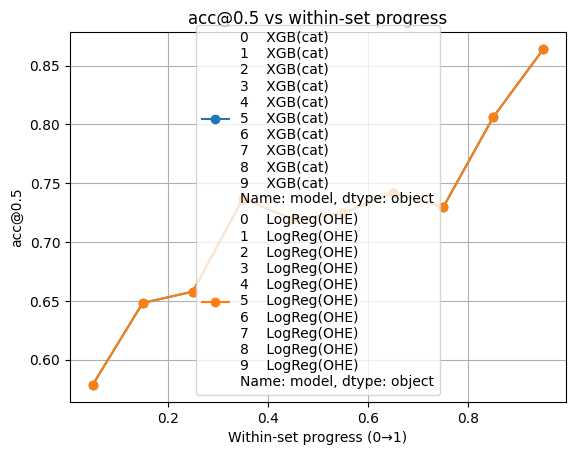

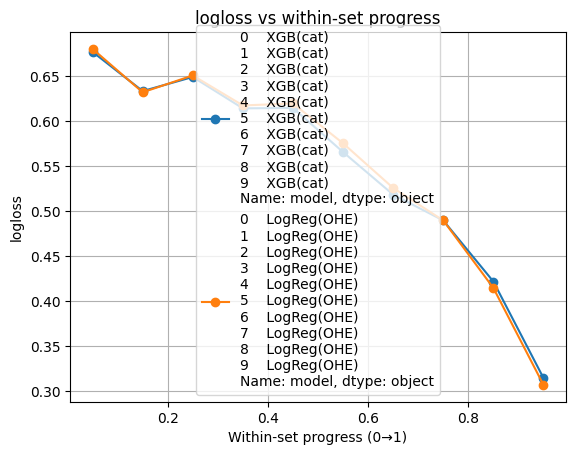

In [ ]:
# %% Install + imports
!pip -q install xgboost==2.0.3

import os, glob
import numpy as np
import pandas as pd

from sklearn.metrics import (
    roc_auc_score, average_precision_score, log_loss,
    brier_score_loss, accuracy_score
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer

import xgboost as xgb
from xgboost.callback import EarlyStopping

# =========================
# CONFIG
# =========================
ROOT = "/content/drive/MyDrive/Winrate predictions"   # change if needed
PATTERN = os.path.join(ROOT, "**", "*_with_ball_counts_v4_SLIM.xlsx")
OUT_DIR = ROOT

MIRROR_AUGMENT = True     # mirror (swap teams/balls & flip label) to remove team bias
DEDUP_WITHIN_SET = False  # optional
SEED = 42

# =========================
# Helpers
# =========================
def norm_col(s): return str(s).strip().lower().replace(" ", "_")

def is_end(row):
    dk = str(row.get("definitionkey","")).strip().lower()
    t  = str(row.get("title","")).strip().lower()
    return (dk in {"point_win","point_lose"}) or (t in {"point_win","point_lose"})

def outcome_from_end(last_row):
    dk = str(last_row.get("definitionkey","")).strip().lower()
    t  = str(last_row.get("title","")).strip().lower()
    key = dk if dk in {"point_win","point_lose"} else t
    if key == "point_win":  return 1
    if key == "point_lose": return 0
    return np.nan

def load_file(fp):
    df = pd.read_excel(fp)
    df.columns = [norm_col(c) for c in df.columns]
    df = df.rename(columns={"team_0_left":"team0_left","team_1_left":"team1_left","ball__t1":"ball_t1"})
    for c in ["team0_left","team1_left","ball_t0","ball_t1","time","eventid","team"]:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    sort_cols = [c for c in ["reviewid","eventid","time"] if c in df.columns]
    if sort_cols: df = df.sort_values(sort_cols).reset_index(drop=True)
    else:         df = df.reset_index(drop=True)
    return df

def add_set_id(df):
    if "reviewid" not in df.columns: df["reviewid"] = "unknown"
    end_flag = df.apply(is_end, axis=1).astype(int)
    df["set_end_flag"] = end_flag
    df["cumsum_end"]   = df.groupby("reviewid")["set_end_flag"].cumsum()
    # keep end row in its set
    df["set_id"] = (df["cumsum_end"] - df["set_end_flag"]).astype(int)
    return df

def eval_block(name, y_true, proba):
    proba = np.clip(proba, 1e-7, 1 - 1e-7)
    auc = roc_auc_score(y_true, proba)
    ap  = average_precision_score(y_true, proba)
    ll  = log_loss(y_true, proba)
    br  = brier_score_loss(y_true, proba)
    acc = accuracy_score(y_true, (proba >= 0.5).astype(int))
    print(f"{name}: AUC={auc:.4f}  AP={ap:.4f}  LogLoss={ll:.4f}  Brier={br:.4f}  Acc@0.5={acc:.4f}")
    return {"AUC":auc,"AP":ap,"LogLoss":ll,"Brier":br,"Acc@0.5":acc}

# =========================
# Build dataset
# =========================
# =========================
# Build dataset (same as before, but keep time + within-set position)
# =========================
files = sorted(glob.glob(PATTERN, recursive=True))
assert files, f"No files found for {PATTERN}"
print(f"Found {len(files)} SLIM files")

rows = []
for fp in files:
    try:
        df = load_file(fp)
        need = {"definitionkey","title","ball_t0","ball_t1","team0_left","team1_left","time"}
        if not need.issubset(df.columns):
            print("[Skip] missing required cols in", os.path.basename(fp)); continue
        df = add_set_id(df)

        for (rid, sid), g in df.groupby(["reviewid","set_id"], sort=False):
            last = g.iloc[-1]
            if not is_end(last): continue
            y = outcome_from_end(last)
            if np.isnan(y): continue

            mask = (
                g["ball_t0"].notna() & g["ball_t1"].notna() &
                g["team0_left"].notna() & g["team1_left"].notna()
            )
            gg = g.loc[mask, ["reviewid","set_id","time","team0_left","team1_left","ball_t0","ball_t1"]].copy()
            if gg.empty: continue

            if DEDUP_WITHIN_SET:
                gg = gg.drop_duplicates(subset=["team0_left","team1_left","ball_t0","ball_t1","time"])

            gg["y"] = int(y)
            gg["set_key"] = gg["reviewid"].astype(str) + "_" + gg["set_id"].astype(str)
            # within-set position
            gg = gg.sort_values("time").reset_index(drop=True)
            gg["row_idx"]  = np.arange(len(gg))
            gg["row_frac"] = (gg["row_idx"] + 1) / len(gg)  # in (0,1]
            rows.append(gg)
    except Exception as e:
        print("[Error]", os.path.basename(fp), "->", e)

data = pd.concat(rows, ignore_index=True)
print("Raw rows:", len(data), "| sets:", data["set_key"].nunique())

# Enforce total balls == 6
keep = (data["ball_t0"].round().astype(int) + data["ball_t1"].round().astype(int)) == 6
if (~keep).any():
    print("Filtered rows with total balls != 6:", (~keep).sum())
data = data[keep].copy()

# Mirror augmentation to kill team bias (keeps row_idx/row_frac)
if MIRROR_AUGMENT:
    mir = data.copy()
    mir["team0_left"], mir["team1_left"] = data["team1_left"].values, data["team0_left"].values
    mir["ball_t0"],   mir["ball_t1"]     = data["ball_t1"].values,   data["ball_t0"].values
    mir["y"]          = 1 - data["y"].values
    mir["is_mirrored"] = 1
    data["is_mirrored"] = 0
    data = pd.concat([data, mir], ignore_index=True)
    print("After mirroring, rows:", len(data))

# =========================
# Categorical features (FIXED)
# =========================
# Coerce to numeric first (guards against '6' strings, etc.)
for c in ["team0_left","team1_left","ball_t0","ball_t1"]:
    data[c] = pd.to_numeric(data[c], errors="coerce")

# Build pair as *strings* on both sides
t0 = data["team0_left"].astype("Int64")
t1 = data["team1_left"].astype("Int64")
data["players_pair_cat"] = (t0.astype(str) + "_" + t1.astype(str))

# ball_t0 as a small categorical (0..6); ball_t1 is implied (6 - ball_t0)
data["ball_t0_cat"] = data["ball_t0"].astype("Int64")

# Explicit category spaces so splits are consistent
players_pairs_all = [f"{i}_{j}" for i in range(7) for j in range(7)]
ball_states_all   = list(range(7))  # 0..6

data["players_pair_cat"] = pd.Categorical(data["players_pair_cat"],
                                          categories=players_pairs_all, ordered=False)
data["ball_t0_cat"]      = pd.Categorical(data["ball_t0_cat"],
                                          categories=ball_states_all,   ordered=False)

TARGET    = "y"
CAT_FEATS = ["players_pair_cat", "ball_t0_cat"]
KEEP_COLS= ["reviewid","set_id","set_key","time","row_idx","row_frac","is_mirrored"] + CAT_FEATS + [TARGET]

# Grouped split by set (no leakage)
rng = np.random.RandomState(SEED)
sets = data["set_key"].unique()
rng.shuffle(sets)
n = len(sets); n_train = int(0.7*n); n_val = int(0.15*n)
train_sets = set(sets[:n_train])
val_sets   = set(sets[n_train:n_train+n_val])
test_sets  = set(sets[n_train+n_val:])

train = data[data["set_key"].isin(train_sets)][KEEP_COLS].copy()
val   = data[data["set_key"].isin(val_sets)][KEEP_COLS].copy()
test  = data[data["set_key"].isin(test_sets)][KEEP_COLS].copy()

# sync categories across splits
for col in CAT_FEATS:
    train[col] = train[col].cat.set_categories(data[col].cat.categories)
    val[col]   = val[col].cat.set_categories(data[col].cat.categories)
    test[col]  = test[col].cat.set_categories(data[col].cat.categories)

y_train, y_val, y_test = train[TARGET].values, val[TARGET].values, test[TARGET].values

print("Sets -> train/val/test:", len(train_sets), len(val_sets), len(test_sets))
print("Rows -> train/val/test:", len(train), len(val), len(test))

# =========================
# XGBoost (native categorical)
# =========================
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    reg_alpha=0.0,
    tree_method="hist",
    enable_categorical=True,
    random_state=SEED,
    eval_metric="logloss",
)
callbacks = [EarlyStopping(rounds=100, save_best=True, maximize=False)]

# NumPy 2.0 alias shim
if not hasattr(np, "NaN"): np.NaN = np.nan

Xtr_xgb = train[CAT_FEATS]
Xva_xgb = val[CAT_FEATS]
Xte_xgb = test[CAT_FEATS]

xgb_clf.fit(
    Xtr_xgb, y_train,
    eval_set=[(Xtr_xgb, y_train), (Xva_xgb, y_val)],
    callbacks=callbacks,
    verbose=50
)

p_tr_xgb = xgb_clf.predict_proba(Xtr_xgb)[:,1]
p_va_xgb = xgb_clf.predict_proba(Xva_xgb)[:,1]
p_te_xgb = xgb_clf.predict_proba(Xte_xgb)[:,1]

print("\n== XGBoost (categorical) ==")
eval_block("TRAIN", y_train, p_tr_xgb)
eval_block("VAL  ", y_val,   p_va_xgb)
eval_block("TEST ", y_test,  p_te_xgb)

# =========================
# Logistic Regression (one-hot, version-safe)
# =========================
try:
    ohe = OneHotEncoder(
        categories=[players_pairs_all, ball_states_all],
        handle_unknown="ignore",
        sparse_output=True,   # sklearn >=1.2
    )
except TypeError:
    ohe = OneHotEncoder(
        categories=[players_pairs_all, ball_states_all],
        handle_unknown="ignore",
        sparse=True,          # sklearn <1.2
    )

logreg = Pipeline([
    ("ohe", ohe),
    ("clf", LogisticRegression(max_iter=5000, class_weight="balanced", random_state=SEED))
])

Xtr_lr = train[CAT_FEATS]
Xva_lr = val[CAT_FEATS]
Xte_lr = test[CAT_FEATS]

logreg.fit(Xtr_lr, y_train)

p_tr_lr = logreg.predict_proba(Xtr_lr)[:,1]
p_va_lr = logreg.predict_proba(Xva_lr)[:,1]
p_te_lr = logreg.predict_proba(Xte_lr)[:,1]

print("\n== Logistic Regression (One-Hot) ==")
eval_block("TRAIN", y_train, p_tr_lr)
eval_block("VAL  ", y_val,   p_va_lr)
eval_block("TEST ", y_test,  p_te_lr)

# =========================
# Accuracy (and log loss) over time within the set
# =========================
def metrics_over_time(df, y_true, proba, n_bins=10, label="model"):
    out = df[["row_frac"]].copy()
    out["y"] = y_true
    out["p"] = proba
    # bin by within-set progress (0,1]
    edges = np.linspace(0.0, 1.0, n_bins+1)
    out["bin"] = pd.cut(out["row_frac"], bins=edges, include_lowest=True, labels=False)

    # aggregate
    agg = (
        out.groupby("bin")
           .apply(lambda g: pd.Series({
               "count": len(g),
               "acc@0.5": accuracy_score(g["y"], (g["p"]>=0.5).astype(int)),
               "logloss": log_loss(g["y"], np.clip(g["p"],1e-7,1-1e-7)),
               "brier":   brier_score_loss(g["y"], g["p"]),
           }))
           .reset_index()
    )
    agg["progress_mid"] = (agg["bin"] + 0.5) / n_bins
    agg["model"] = label
    return agg[["model","bin","progress_mid","count","acc@0.5","logloss","brier"]]

mt_xgb = metrics_over_time(test, y_test, p_te_xgb, n_bins=10, label="XGB(cat)")
mt_lr  = metrics_over_time(test, y_test, p_te_lr,  n_bins=10, label="LogReg(OHE)")

print("\nAccuracy & loss vs. within-set progress (deciles):")
display(pd.concat([mt_xgb, mt_lr], ignore_index=True).round(4))

# (Optional) Plot in Colab
import matplotlib.pyplot as plt

for metric in ["acc@0.5","logloss"]:
    plt.figure()
    for mt, color in [(mt_xgb, None), (mt_lr, None)]:
        plt.plot(mt["progress_mid"], mt[metric], marker="o", label=mt["model"])
    plt.xlabel("Within-set progress (0→1)")
    plt.ylabel(metric)
    plt.title(f"{metric} vs within-set progress")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# =========================
# Save per-row predictions for inspection
# =========================
def _build_pred_df(df, y_true, p_xgb, p_lr, split_name):
    out = df[[
        "reviewid","set_id","set_key","time","row_idx","row_frac",
        "is_mirrored","players_pair_cat","ball_t0_cat"
    ]].copy()

    # Decode categorical features back to integers
    pp = out["players_pair_cat"].astype(str).str.split("_", n=1, expand=True)
    out["team0_left"] = pd.to_numeric(pp[0], errors="coerce").astype("Int64")
    out["team1_left"] = pd.to_numeric(pp[1], errors="coerce").astype("Int64")
    out["ball_t0"]    = pd.to_numeric(out["ball_t0_cat"].astype(str), errors="coerce").astype("Int64")
    out["ball_t1"]    = 6 - out["ball_t0"]

    # Targets & predictions
    out["y"]      = y_true
    out["p_xgb"]  = p_xgb
    out["p_lr"]   = p_lr
    out["p_avg"]  = out[["p_xgb","p_lr"]].mean(axis=1)   # simple ensemble (optional)
    out["pred_xgb"] = (out["p_xgb"] >= 0.5).astype(int)
    out["pred_lr"]  = (out["p_lr"]  >= 0.5).astype(int)
    out["pred_avg"] = (out["p_avg"] >= 0.5).astype(int)
    out["split"]    = split_name

    cols = [
        "split","reviewid","set_id","set_key","time","row_idx","row_frac","is_mirrored",
        "team0_left","team1_left","ball_t0","ball_t1",
        "y","p_xgb","p_lr","p_avg","pred_xgb","pred_lr","pred_avg"
    ]
    return out[cols].sort_values(["set_key","time","row_idx"]).reset_index(drop=True)

pred_train = _build_pred_df(train, y_train, p_tr_xgb, p_tr_lr, "train")
pred_val   = _build_pred_df(val,   y_val,   p_va_xgb, p_va_lr, "val")
pred_test  = _build_pred_df(test,  y_test,  p_te_xgb, p_te_lr, "test")

pred_all = pd.concat([pred_train, pred_val, pred_test], ignore_index=True)

PRED_CSV = os.path.join(OUT_DIR, "row_level_predictions_SLIM.csv")
pred_all.to_csv(PRED_CSV, index=False)
print("Saved row predictions ->", PRED_CSV)
display(pred_all.head(10))


Saved row predictions -> /content/drive/MyDrive/Winrate predictions/row_level_predictions_SLIM.csv


,split,reviewid,set_id,set_key,time,row_idx,row_frac,is_mirrored,team0_left,team1_left,ball_t0,ball_t1,y,p_xgb,p_lr,p_avg,pred_xgb,pred_lr,pred_avg
0,train,01d7c3a8-0625-4e71-adc1-6420cc0f5390,0,01d7c3a8-0625-4e71-adc1-6420cc0f5390_0,16.492500,0,0.038462,0,6,6,3,3,0,0.499081,0.499968,0.499524,0,0,0
1,train,01d7c3a8-0625-4e71-adc1-6420cc0f5390,0,01d7c3a8-0625-4e71-adc1-6420cc0f5390_0,16.492500,0,0.038462,1,6,6,3,3,1,0.499081,0.499968,0.499524,0,0,0
2,train,01d7c3a8-0625-4e71-adc1-6420cc0f5390,0,01d7c3a8-0625-4e71-adc1-6420cc0f5390_0,16.680000,1,0.076923,0,6,6,2,4,0,0.529814,0.508565,0.519189,1,1,1
3,train,01d7c3a8-0625-4e71-adc1-6420cc0f5390,0,01d7c3a8-0625-4e71-adc1-6420cc0f5390_0,16.680000,1,0.076923,1,6,6,4,2,1,0.468556,0.491251,0.479903,0,0,0
4,train,01d7c3a8-0625-4e71-adc1-6420cc0f5390,0,01d7c3a8-0625-4e71-adc1-6420cc0f5390_0,19.928694,2,0.115385,0,6,6,1,5,0,0.481344,0.445030,0.463187,0,0,0
5,train,01d7c3a8-0625-4e71-adc1-6420cc0f5390,0,01d7c3a8-0625-4e71-adc1-6420cc0f5390_0,19.928694,2,0.115385,1,6,6,5,1,1,0.517057,0.554852,0.535955,1,1,1
6,train,01d7c3a8-0625-4e71-adc1-6420cc0f5390,0,01d7c3a8-0625-4e71-adc1-6420cc0f5390_0,21.052632,3,0.153846,0,6,6,2,4,0,0.529814,0.508565,0.519189,1,1,1
7,train,01d7c3a8-0625-4e71-adc1-6420cc0f5390,0,01d7c3a8-0625-4e71-adc1-6420cc0f5390_0,21.052632,3,0.153846,1,6,6,4,2,1,0.468556,0.491251,0.479903,0,0,0
8,train,01d7c3a8-0625-4e71-adc1-6420cc0f5390,0,01d7c3a8-0625-4e71-adc1-6420cc0f5390_0,21.879495,4,0.192308,0,6,6,3,3,0,0.499081,0.499968,0.499524,0,0,0
9,train,01d7c3a8-0625-4e71-adc1-6420cc0f5390,0,01d7c3a8-0625-4e71-adc1-6420cc0f5390_0,21.879495,4,0.192308,1,6,6,3,3,1,0.499081,0.499968,0.499524,0,0,0


In [ ]:
# %% Install + imports
!pip -q install xgboost==2.0.3

import os, glob, hashlib
import numpy as np
import pandas as pd

from sklearn.metrics import (
    roc_auc_score, average_precision_score, log_loss,
    brier_score_loss, accuracy_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost.callback import EarlyStopping

# =============== CONFIG ===============
ROOT    = "/content/drive/MyDrive/Winrate predictions"   # <- change if needed
PATTERN = os.path.join(ROOT, "**", "*_with_ball_counts_v4_SLIM.xlsx")
OUT_DIR = ROOT
SEED    = 42
DEDUP_WITHIN_SET = False       # optional; keep False unless you want 1 row per unique state within a set
BALL_SUM = 6                   # balls on court (your data uses 6)

# =============== Helpers ===============
def norm_col(s): return str(s).strip().lower().replace(" ", "_")

def is_end(row):
    dk = str(row.get("definitionkey","")).strip().lower()
    t  = str(row.get("title","")).strip().lower()
    return (dk in {"point_win","point_lose"}) or (t in {"point_win","point_lose"})

def outcome_from_end(last_row):
    dk = str(last_row.get("definitionkey","")).strip().lower()
    t  = str(last_row.get("title","")).strip().lower()
    key = dk if dk in {"point_win","point_lose"} else t
    if key == "point_win":  return 1  # team0 wins the set
    if key == "point_lose": return 0  # team1 wins the set
    return np.nan

def load_file(fp):
    df = pd.read_excel(fp)
    df.columns = [norm_col(c) for c in df.columns]
    df = df.rename(columns={"team_0_left":"team0_left","team_1_left":"team1_left","ball__t1":"ball_t1"})
    for c in ["team0_left","team1_left","ball_t0","ball_t1","time","eventid","team"]:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    sort_cols = [c for c in ["reviewid","eventid","time"] if c in df.columns]
    if sort_cols: df = df.sort_values(sort_cols).reset_index(drop=True)
    else:         df = df.reset_index(drop=True)
    return df

def add_set_id(df):
    if "reviewid" not in df.columns: df["reviewid"] = "unknown"
    end_flag = df.apply(is_end, axis=1).astype(int)
    df["set_end_flag"] = end_flag
    df["cumsum_end"]   = df.groupby("reviewid")["set_end_flag"].cumsum()
    # Keep end row in its set
    df["set_id"] = (df["cumsum_end"] - df["set_end_flag"]).astype(int)
    return df

def stable_tiebreak_key(set_key, time_val):
    # Deterministic bit for final tie-breaking
    s = f"{set_key}|{time_val}"
    return hashlib.md5(s.encode("utf-8")).digest()[-1] & 1  # 0 or 1

def canonicalize_row(t0, t1, b0, b1, set_key, time_val):
    """
    Choose a canonical orientation:
      1) Side A has MORE balls
      2) If tie, side A has MORE players left
      3) If tie, use stable hash to decide
    Returns: (tA,tB,bA,bB, swap)
    where 'swap=True' means we swapped original (team0, team1) -> (A, B).
    """
    swap = False
    if (b0 < b1) or (b0 == b1 and t0 < t1) or (b0 == b1 and t0 == t1 and stable_tiebreak_key(set_key, time_val)==1):
        t0, t1, b0, b1 = t1, t0, b1, b0
        swap = True
    return t0, t1, b0, b1, swap

def eval_block(name, y_true, proba):
    proba = np.clip(proba, 1e-7, 1 - 1e-7)
    auc = roc_auc_score(y_true, proba)
    ap  = average_precision_score(y_true, proba)
    ll  = log_loss(y_true, proba)
    br  = brier_score_loss(y_true, proba)
    acc = accuracy_score(y_true, (proba >= 0.5).astype(int))
    print(f"{name}: AUC={auc:.4f}  AP={ap:.4f}  LogLoss={ll:.4f}  Brier={br:.4f}  Acc@0.5={acc:.4f}")
    return {"AUC":auc,"AP":ap,"LogLoss":ll,"Brier":br,"Acc@0.5":acc}

# =============== Build dataset (CANONICAL) ===============
files = sorted(glob.glob(PATTERN, recursive=True))
assert files, f"No files found for {PATTERN}"
print(f"Found {len(files)} SLIM files")

rows = []
for fp in files:
    try:
        df = load_file(fp)
        need = {"definitionkey","title","ball_t0","ball_t1","team0_left","team1_left","time"}
        if not need.issubset(df.columns):
            print("[Skip] missing cols in", os.path.basename(fp)); continue
        df = add_set_id(df)

        for (rid, sid), g in df.groupby(["reviewid","set_id"], sort=False):
            last = g.iloc[-1]
            if not is_end(last): continue
            y_team0 = outcome_from_end(last)      # 1 if original team0 wins the set
            if np.isnan(y_team0): continue

            # keep only rows with all four counts
            mask = (
                g["ball_t0"].notna() & g["ball_t1"].notna() &
                g["team0_left"].notna() & g["team1_left"].notna()
            )
            gg = g.loc[mask, ["reviewid","set_id","time","team0_left","team1_left","ball_t0","ball_t1"]].copy()
            if gg.empty: continue

            if DEDUP_WITHIN_SET:
                gg = gg.drop_duplicates(subset=["team0_left","team1_left","ball_t0","ball_t1","time"])

            # within-set position (for later analysis)
            gg = gg.sort_values("time").reset_index(drop=True)
            gg["row_idx"]  = np.arange(len(gg))
            gg["row_frac"] = (gg["row_idx"] + 1) / len(gg)
            gg["reviewid"] = gg["reviewid"].astype(str)
            gg["set_key"]  = gg["reviewid"] + "_" + gg["set_id"].astype(str)

            # canonicalize each row
            recs = []
            for r in gg.itertuples(index=False):
                t0, t1 = int(r.team0_left), int(r.team1_left)
                b0, b1 = int(r.ball_t0),   int(r.ball_t1)
                # enforce total balls
                if b0 + b1 != BALL_SUM:
                    continue
                tA, tB, bA, bB, swapped = canonicalize_row(t0, t1, b0, b1, r.set_key, r.time)
                # label: P(A wins) -> flip if we swapped original orientation
                y_A = y_team0 if not swapped else (1 - y_team0)
                recs.append({
                    "reviewid": r.reviewid, "set_id": r.set_id, "set_key": r.set_key,
                    "time": r.time, "row_idx": r.row_idx, "row_frac": r.row_frac,
                    "tA": tA, "tB": tB, "bA": bA, "bB": bB, "swapped": int(swapped),
                    "y_Awins": int(y_A),     # target for training
                    "y_team0": int(y_team0)  # original semantics (for reporting)
                })
            if recs:
                rows.append(pd.DataFrame.from_records(recs))
    except Exception as e:
        print("[Error]", os.path.basename(fp), "->", e)

data = pd.concat(rows, ignore_index=True)
print("Canonical rows:", len(data), "| sets:", data["set_key"].nunique())

# Categorical features
data["players_pair_cat"] = (data["tA"].astype("Int64").astype(str) + "_" + data["tB"].astype("Int64").astype(str))
data["ball_t0_cat"]      = data["bA"].astype("Int64")

players_pairs_all = [f"{i}_{j}" for i in range(7) for j in range(7)]
ball_states_all   = list(range(7))

data["players_pair_cat"] = pd.Categorical(data["players_pair_cat"], categories=players_pairs_all, ordered=False)
data["ball_t0_cat"]      = pd.Categorical(data["ball_t0_cat"],      categories=ball_states_all,   ordered=False)

TARGET    = "y_Awins"                      # model learns P(A wins)
CAT_FEATS = ["players_pair_cat", "ball_t0_cat"]
KEEP_COLS = ["reviewid","set_id","set_key","time","row_idx","row_frac","swapped","tA","tB","bA","bB","y_team0"] + CAT_FEATS + [TARGET]

# grouped split by set (no leakage)
rng = np.random.RandomState(SEED)
sets = data["set_key"].unique()
rng.shuffle(sets)
n = len(sets); n_train = int(0.7*n); n_val = int(0.15*n)
train_sets = set(sets[:n_train])
val_sets   = set(sets[n_train:n_train+n_val])
test_sets  = set(sets[n_train+n_val:])

train = data[data["set_key"].isin(train_sets)][KEEP_COLS].copy()
val   = data[data["set_key"].isin(val_sets)][KEEP_COLS].copy()
test  = data[data["set_key"].isin(test_sets)][KEEP_COLS].copy()

# Sync categories
for c in CAT_FEATS:
    train[c] = train[c].cat.set_categories(data[c].cat.categories)
    val[c]   = val[c].cat.set_categories(data[c].cat.categories)
    test[c]  = test[c].cat.set_categories(data[c].cat.categories)

y_tr, y_va, y_te = train[TARGET].values, val[TARGET].values, test[TARGET].values

print("Sets -> train/val/test:", len(train_sets), len(val_sets), len(test_sets))
print("Rows -> train/val/test:", len(train), len(val), len(test))

# =============== Model A: XGBoost (native categorical) ===============
# NumPy 2.0 alias (compat for some libs)
if not hasattr(np, "NaN"): np.NaN = np.nan

xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    tree_method="hist",
    enable_categorical=True,
    random_state=SEED,
    eval_metric="logloss",
)
callbacks = [EarlyStopping(rounds=100, save_best=True, maximize=False)]

Xtr_xgb = train[CAT_FEATS]
Xva_xgb = val[CAT_FEATS]
Xte_xgb = test[CAT_FEATS]

xgb_clf.fit(
    Xtr_xgb, y_tr,
    eval_set=[(Xtr_xgb, y_tr), (Xva_xgb, y_va)],
    callbacks=callbacks,
    verbose=50
)

p_tr_A = xgb_clf.predict_proba(Xtr_xgb)[:,1]
p_va_A = xgb_clf.predict_proba(Xva_xgb)[:,1]
p_te_A = xgb_clf.predict_proba(Xte_xgb)[:,1]

print("\n== XGB (P(A wins)) ==")
eval_block("TRAIN", y_tr, p_tr_A)
eval_block("VAL  ", y_va, p_va_A)
eval_block("TEST ", y_te, p_te_A)

# Convert to original semantics: P(team0 wins) = p_A if not swapped else 1 - p_A
p_tr_team0 = np.where(train["swapped"].values==1, 1 - p_tr_A, p_tr_A)
p_va_team0 = np.where(val["swapped"].values==1,   1 - p_va_A, p_va_A)
p_te_team0 = np.where(test["swapped"].values==1,  1 - p_te_A, p_te_A)

print("\n== XGB (P(team0 wins)) ==")
eval_block("TRAIN", train["y_team0"].values, p_tr_team0)
eval_block("VAL  ", val["y_team0"].values,   p_va_team0)
eval_block("TEST ", test["y_team0"].values,  p_te_team0)

# =============== Model B: Logistic Regression (one-hot) ===============
try:
    ohe = OneHotEncoder(categories=[players_pairs_all, ball_states_all],
                        handle_unknown="ignore", sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(categories=[players_pairs_all, ball_states_all],
                        handle_unknown="ignore", sparse=True)

logreg = Pipeline([
    ("ohe", ohe),
    ("clf", LogisticRegression(max_iter=5000, class_weight="balanced", random_state=SEED))
])

Xtr_lr = train[CAT_FEATS]
Xva_lr = val[CAT_FEATS]
Xte_lr = test[CAT_FEATS]

logreg.fit(Xtr_lr, y_tr)

p_tr_A_lr = logreg.predict_proba(Xtr_lr)[:,1]
p_va_A_lr = logreg.predict_proba(Xva_lr)[:,1]
p_te_A_lr = logreg.predict_proba(Xte_lr)[:,1]

print("\n== LogReg (P(A wins)) ==")
eval_block("TRAIN", y_tr, p_tr_A_lr)
eval_block("VAL  ", y_va, p_va_A_lr)
eval_block("TEST ", y_te, p_te_A_lr)

p_tr_team0_lr = np.where(train["swapped"].values==1, 1 - p_tr_A_lr, p_tr_A_lr)
p_va_team0_lr = np.where(val["swapped"].values==1,   1 - p_va_A_lr, p_va_A_lr)
p_te_team0_lr = np.where(test["swapped"].values==1,  1 - p_te_A_lr, p_te_A_lr)

print("\n== LogReg (P(team0 wins)) ==")
eval_block("TRAIN", train["y_team0"].values, p_tr_team0_lr)
eval_block("VAL  ", val["y_team0"].values,   p_va_team0_lr)
eval_block("TEST ", test["y_team0"].values,  p_te_team0_lr)

# =============== Accuracy / loss over set progress (optional) ===============
def metrics_over_time(df, y_true, proba, n_bins=10, label="model"):
    out = df[["row_frac"]].copy()
    out["y"] = y_true
    out["p"] = proba
    edges = np.linspace(0.0, 1.0, n_bins+1)
    out["bin"] = pd.cut(out["row_frac"], bins=edges, include_lowest=True, labels=False)
    agg = (out.groupby("bin")
              .apply(lambda g: pd.Series({
                  "count": len(g),
                  "acc@0.5": accuracy_score(g["y"], (g["p"]>=0.5).astype(int)),
                  "logloss": log_loss(g["y"], np.clip(g["p"],1e-7,1-1e-7)),
                  "brier":   brier_score_loss(g["y"], g["p"]),
              }))
              .reset_index())
    agg["progress_mid"] = (agg["bin"] + 0.5) / n_bins
    agg["model"] = label
    return agg[["model","bin","progress_mid","count","acc@0.5","logloss","brier"]]

mt_xgb = metrics_over_time(test, test["y_team0"].values, p_te_team0,   n_bins=10, label="XGB(team0)")
mt_lr  = metrics_over_time(test, test["y_team0"].values, p_te_team0_lr, n_bins=10, label="LogReg(team0)")
print("\nAccuracy & loss vs within-set progress (deciles):")
display(pd.concat([mt_xgb, mt_lr], ignore_index=True).round(4))

# =============== Save per-row predictions ===============
pred = test[["reviewid","set_id","set_key","time","row_idx","row_frac","swapped","tA","tB","bA","bB","y_team0"]].copy()
pred["p_xgb_A"]     = p_te_A
pred["p_lr_A"]      = p_te_A_lr
pred["p_xgb_team0"] = p_te_team0
pred["p_lr_team0"]  = p_te_team0_lr
pred["p_avg_team0"] = pred[["p_xgb_team0","p_lr_team0"]].mean(axis=1)
pred["pred_avg_t0"] = (pred["p_avg_team0"] >= 0.5).astype(int)

PRED_CSV = os.path.join(OUT_DIR, "row_level_predictions_CANON.csv")
pred.sort_values(["set_key","time","row_idx"]).to_csv(PRED_CSV, index=False)
print("Saved canonical row-level predictions ->", PRED_CSV)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 4.3 MB/s eta 0:00:00
Found 58 SLIM files
Canonical rows: 24107 | sets: 761
Sets -> train/val/test: 532 114 115
Rows -> train/val/test: 16737 3597 3773
[0]	validation_0-logloss:0.68799	validation_1-logloss:0.68534


/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-logloss:0.56014	validation_1-logloss:0.53929
[100]	validation_0-logloss:0.54505	validation_1-logloss:0.52421
[150]	validation_0-logloss:0.54091	validation_1-logloss:0.52222
[200]	validation_0-logloss:0.53925	validation_1-logloss:0.52136
[250]	validation_0-logloss:0.53856	validation_1-logloss:0.52149
[300]	validation_0-logloss:0.53831	validation_1-logloss:0.52183
[324]	validation_0-logloss:0.53824	validation_1-logloss:0.52187

== XGB (P(A wins)) ==
TRAIN: AUC=0.7968  AP=0.7818  LogLoss=0.5388  Brier=0.1832  Acc@0.5=0.7170
VAL  : AUC=0.8181  AP=0.7910  LogLoss=0.5210  Brier=0.1745  Acc@0.5=0.7253
TEST : AUC=0.7969  AP=0.7760  LogLoss=0.5476  Brier=0.1829  Acc@0.5=0.7265

== XGB (P(team0 wins)) ==
TRAIN: AUC=0.7971  AP=0.8010  LogLoss=0.5388  Brier=0.1832  Acc@0.5=0.7170
VAL  : AUC=0.8193  AP=0.7920  LogLoss=0.5210  Brier=0.1745  Acc@0.5=0.7253
TEST : AUC=0.7965  AP=0.8056  LogLoss=0.5476  Brier=0.1829  Acc@0.5=0.7265

== LogReg (P(A wins)) ==
TRAIN: AUC=0.7967  AP=0.780

/tmp/ipython-input-3452247636.py:288: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
/tmp/ipython-input-3452247636.py:288: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,model,bin,progress_mid,count,acc@0.5,logloss,brier
0,XGB(team0),0,0.05,325.0,0.5815,0.6729,0.2400
1,XGB(team0),1,0.15,378.0,0.6349,0.6360,0.2209
2,XGB(team0),2,0.25,377.0,0.6525,0.6574,0.2273
3,XGB(team0),3,0.35,380.0,0.7500,0.6267,0.2007
4,XGB(team0),4,0.45,401.0,0.7132,0.6279,0.2022
5,XGB(team0),5,0.55,352.0,0.7074,0.5816,0.1918
6,XGB(team0),6,0.65,374.0,0.7059,0.5301,0.1780
7,XGB(team0),7,0.75,383.0,0.7624,0.4862,0.1640
8,XGB(team0),8,0.85,372.0,0.8091,0.4082,0.1344
9,XGB(team0),9,0.95,431.0,0.9026,0.2974,0.0893


Saved canonical row-level predictions -> /content/drive/MyDrive/Winrate predictions/row_level_predictions_CANON.csv


In [ ]:
# =========================
# Symmetry check + Ball effect (grid) + Save to Excel
# =========================
!pip -q install openpyxl
from datetime import datetime

def predict_team0_for_state(model, t0, t1, b0, set_key="GRID", time_val=0):
    """Predict P(team0 wins) for a raw state using the canonical mapping."""
    b1 = BALL_SUM - b0
    # canonicalize to (A,B)
    tA, tB, bA, bB, swapped = canonicalize_row(t0, t1, b0, b1, set_key, time_val)
    X = pd.DataFrame({
        "players_pair_cat": [f"{tA}_{tB}"],
        "ball_t0_cat":      [bA],
    })
    # ensure categorical dtypes/cats match the trained models
    X["players_pair_cat"] = pd.Categorical(X["players_pair_cat"], categories=players_pairs_all, ordered=False)
    X["ball_t0_cat"]      = pd.Categorical(X["ball_t0_cat"],      categories=ball_states_all,   ordered=False)
    # predict P(A wins) then uncanonicalize to P(team0 wins)
    pA = model.predict_proba(X[CAT_FEATS])[:, 1][0]
    return (1 - pA) if swapped else pA

# --- Build the small grid (7x7x7 = 343 states)
grid = []
for t0 in range(7):
    for t1 in range(7):
        for b0 in range(7):
            grid.append({"t0": t0, "t1": t1, "b0": b0, "b1": BALL_SUM - b0})
grid_df = pd.DataFrame(grid)
grid_df["ball_adv"] = grid_df["b0"] - grid_df["b1"]  # ∈ {-6,-4,-2,0,2,4,6}

# --- Predict with both models
px_xgb = []
px_lr  = []
for r in grid_df.itertuples(index=False):
    px_xgb.append(predict_team0_for_state(xgb_clf, r.t0, r.t1, r.b0))
    px_lr.append( predict_team0_for_state(logreg,   r.t0, r.t1, r.b0))
grid_df["p_team0_xgb"] = np.array(px_xgb)
grid_df["p_team0_lr"]  = np.array(px_lr)
grid_df["p_team0_avg"] = grid_df[["p_team0_xgb","p_team0_lr"]].mean(axis=1)

# --- Symmetry check: state vs its mirror (t1,t0, b1)
grid_df["key"]        = grid_df.apply(lambda r: f"{r.t0}_{r.t1}_{r.b0}", axis=1)
grid_df["key_mirror"] = grid_df.apply(lambda r: f"{r.t1}_{r.t0}_{r.b1}", axis=1)
sym = grid_df[["key","key_mirror","p_team0_xgb","p_team0_lr","p_team0_avg"]].merge(
    grid_df[["key","p_team0_xgb","p_team0_lr","p_team0_avg"]].rename(
        columns={"key":"key_mirror","p_team0_xgb":"p_mirror_xgb","p_team0_lr":"p_mirror_lr","p_team0_avg":"p_mirror_avg"}
    ),
    on="key_mirror", how="left"
)
# Complement error: p(state) + (1 - p(mirror)) should be 1
for col in ["xgb","lr","avg"]:
    sym[f"sum_{col}"] = sym[f"p_team0_{col}"] + (1 - sym[f"p_mirror_{col}"])
    sym[f"err_{col}"] = sym[f"sum_{col}"] - 1.0

print("\nSymmetry check (|error| should be near 0):")
for col in ["xgb","lr","avg"]:
    ae = sym[f"err_{col}"].abs()
    print(f"  {col:>3}  mean|err|={ae.mean():.6f}   max|err|={ae.max():.6f}")

# --- Ball effect (overall and with equal players)
def summarize_ball_effect(df, prob_col, label):
    eff_all = (df.groupby("ball_adv")[prob_col]
                 .mean().rename("win_prob").reset_index())
    eff_all["where"] = "all states"
    eff_all["model"] = label

    equal = df[df["t0"] == df["t1"]]
    eff_eq = (equal.groupby("ball_adv")[prob_col]
                .mean().rename("win_prob").reset_index())
    eff_eq["where"] = "players equal"
    eff_eq["model"] = label

    return pd.concat([eff_all, eff_eq], ignore_index=True)

eff_xgb = summarize_ball_effect(grid_df, "p_team0_xgb", "XGB")
eff_lr  = summarize_ball_effect(grid_df, "p_team0_lr",  "LogReg")
eff_avg = summarize_ball_effect(grid_df, "p_team0_avg", "Avg(XGB,LR)")
ball_effect = pd.concat([eff_xgb, eff_lr, eff_avg], ignore_index=True).sort_values(["model","where","ball_adv"])

print("\nBall effect on predicted win rate (averaged):")
display(ball_effect)

# --- Save everything to Excel
XL_PATH = os.path.join(OUT_DIR, f"ball_effect_symmetry_CANON_{datetime.now().strftime('%Y%m%d_%H%M%S')}.xlsx")
with pd.ExcelWriter(XL_PATH, engine="openpyxl") as writer:
    grid_df.sort_values(["t0","t1","b0"]).to_excel(writer, sheet_name="grid_predictions", index=False)
    sym_cols = ["key","key_mirror",
                "p_team0_xgb","p_mirror_xgb","sum_xgb","err_xgb",
                "p_team0_lr","p_mirror_lr","sum_lr","err_lr",
                "p_team0_avg","p_mirror_avg","sum_avg","err_avg"]
    sym[sym_cols].to_excel(writer, sheet_name="symmetry_check", index=False)
    ball_effect.to_excel(writer, sheet_name="ball_effect", index=False)
print("Saved:", XL_PATH)



Symmetry check (|error| should be near 0):
  xgb  mean|err|=nan   max|err|=nan
   lr  mean|err|=nan   max|err|=nan
  avg  mean|err|=nan   max|err|=nan

Ball effect on predicted win rate (averaged):


,ball_adv,win_prob,where,model
28,-6,0.480074,all states,"Avg(XGB,LR)"
29,-4,0.480962,all states,"Avg(XGB,LR)"
30,-2,0.507240,all states,"Avg(XGB,LR)"
31,0,0.500260,all states,"Avg(XGB,LR)"
32,2,0.492760,all states,"Avg(XGB,LR)"
33,4,0.519038,all states,"Avg(XGB,LR)"
34,6,0.519926,all states,"Avg(XGB,LR)"
35,-6,0.477177,players equal,"Avg(XGB,LR)"
36,-4,0.478833,players equal,"Avg(XGB,LR)"
37,-2,0.523894,players equal,"Avg(XGB,LR)"


Saved: /content/drive/MyDrive/Winrate predictions/ball_effect_symmetry_CANON_20250903_154116.xlsx


In [ ]:
# =========================
# Monotone XGB with symmetric features
# =========================
from datetime import datetime

USE_PLAYERS_TOTAL = True  # set False to force 0-adv baseline closer to 0.5

# 1) Build symmetric numeric features for each split
def add_sym_feats(df):
    df = df.copy()
    df["ball_adv"]    = df["bA"] - df["bB"]        # + means A has more balls
    df["player_adv"]  = df["tA"] - df["tB"]        # + means A has more players
    if USE_PLAYERS_TOTAL:
        df["players_total"] = df["tA"] + df["tB"]  # symmetry-preserving context
    return df

train_m = add_sym_feats(train)
val_m   = add_sym_feats(val)
test_m  = add_sym_feats(test)

if USE_PLAYERS_TOTAL:
    NUM_FEATS = ["player_adv", "players_total", "ball_adv"]
    # monotone: player_adv +1, players_total 0, ball_adv +1
    mono_tuple = (1, 0, 1)
else:
    NUM_FEATS = ["player_adv", "ball_adv"]
    mono_tuple = (1, 1)

# 2) Train monotone XGB
xgb_mono = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method="hist",
    monotone_constraints=mono_tuple,
    random_state=SEED,
    eval_metric="logloss",
)
callbacks = [EarlyStopping(rounds=100, save_best=True, maximize=False)]

Xtr_m = train_m[NUM_FEATS]; y_tr_m = y_tr
Xva_m = val_m[NUM_FEATS];   y_va_m = y_va
Xte_m = test_m[NUM_FEATS];  y_te_m = y_te

xgb_mono.fit(
    Xtr_m, y_tr_m,
    eval_set=[(Xtr_m, y_tr_m), (Xva_m, y_va_m)],
    callbacks=callbacks,
    verbose=50
)

# 3) Predict (P(A wins)) and convert to P(team0 wins)
p_tr_A_mono = xgb_mono.predict_proba(Xtr_m)[:,1]
p_va_A_mono = xgb_mono.predict_proba(Xva_m)[:,1]
p_te_A_mono = xgb_mono.predict_proba(Xte_m)[:,1]

print("\n== XGB MONO (P(A wins)) ==")
eval_block("TRAIN", y_tr_m, p_tr_A_mono)
eval_block("VAL  ", y_va_m, p_va_A_mono)
eval_block("TEST ", y_te_m, p_te_A_mono)

p_tr_team0_mono = np.where(train["swapped"].values==1, 1 - p_tr_A_mono, p_tr_A_mono)
p_va_team0_mono = np.where(val["swapped"].values==1,   1 - p_va_A_mono, p_va_A_mono)
p_te_team0_mono = np.where(test["swapped"].values==1,  1 - p_te_A_mono, p_te_A_mono)

print("\n== XGB MONO (P(team0 wins)) ==")
eval_block("TRAIN", train["y_team0"].values, p_tr_team0_mono)
eval_block("VAL  ", val["y_team0"].values,   p_va_team0_mono)
eval_block("TEST ", test["y_team0"].values,  p_te_team0_mono)

# 4) Predict on full (t0,t1,b0) grid with symmetry check
def predict_team0_for_state_mono_sym(model, t0, t1, b0, set_key="GRID", time_val=0):
    b1 = BALL_SUM - b0
    # canonicalize to A/B orientation for labeling
    tA, tB, bA, bB, swapped = canonicalize_row(t0, t1, b0, b1, set_key, time_val)
    # symmetric features
    row = {
        "player_adv":  tA - tB,
        "ball_adv":    bA - bB,
    }
    if USE_PLAYERS_TOTAL:
        row["players_total"] = tA + tB
    X = pd.DataFrame([row])[NUM_FEATS]
    pA = model.predict_proba(X)[:,1][0]
    return (1 - pA) if swapped else pA

grid = []
for t0 in range(7):
    for t1 in range(7):
        for b0 in range(7):
            grid.append({"t0": t0, "t1": t1, "b0": b0, "b1": BALL_SUM - b0})
grid_df_m = pd.DataFrame(grid)
grid_df_m["ball_adv"]   = grid_df_m["b0"] - grid_df_m["b1"]
grid_df_m["player_adv"] = grid_df_m["t0"] - grid_df_m["t1"]

preds = []
for r in grid_df_m.itertuples(index=False):
    preds.append(predict_team0_for_state_mono_sym(xgb_mono, r.t0, r.t1, r.b0))
grid_df_m["p_team0_mono"] = np.array(preds)

# Strict symmetry: p(t0,t1,b0) + (1 - p(t1,t0,b1)) == 1
grid_df_m["key"]        = grid_df_m.apply(lambda r: f"{r.t0}_{r.t1}_{r.b0}", axis=1)
grid_df_m["key_mirror"] = grid_df_m.apply(lambda r: f"{r.t1}_{r.t0}_{r.b1}", axis=1)
sym_m = grid_df_m[["key","key_mirror","p_team0_mono"]].merge(
    grid_df_m[["key","p_team0_mono"]].rename(columns={"key":"key_mirror","p_team0_mono":"p_mirror"}),
    on="key_mirror", how="left"
)
sym_m["sum"] = sym_m["p_team0_mono"] + (1 - sym_m["p_mirror"])
sym_m["err"] = sym_m["sum"] - 1.0
print("\nSymmetry (monotone + symmetric feats): mean|err|=%.6f  max|err|=%.6f"
      % (sym_m["err"].abs().mean(), sym_m["err"].abs().max()))

# 5) Ball effect (overall and players equal)
def summarize_ball_effect(df, prob_col, label):
    eff_all = df.groupby("ball_adv")[prob_col].mean().rename("win_prob").reset_index()
    eff_all["where"] = "all states"; eff_all["model"] = label
    eq = df[df["t0"]==df["t1"]].groupby("ball_adv")[prob_col].mean().rename("win_prob").reset_index()
    eq["where"] = "players equal"; eq["model"] = label
    return pd.concat([eff_all, eq], ignore_index=True)

ball_effect_mono = summarize_ball_effect(grid_df_m, "p_team0_mono", "XGB_MONO_SYM").sort_values(["where","ball_adv"])
print("\nBall effect (MONOTONE + symmetric feats):")
display(ball_effect_mono)

# 6) Save Excel
XL_MONO = os.path.join(OUT_DIR, f"ball_effect_MONOTONE_SYM_{datetime.now().strftime('%Y%m%d_%H%M%S')}.xlsx")
with pd.ExcelWriter(XL_MONO, engine="openpyxl") as w:
    grid_df_m.sort_values(["t0","t1","b0"]).to_excel(w, "grid_predictions_mono", index=False)
    sym_m[["key","key_mirror","p_team0_mono","p_mirror","sum","err"]].to_excel(w, "symmetry_check_mono", index=False)
    ball_effect_mono.to_excel(w, "ball_effect_mono", index=False)
print("Saved:", XL_MONO)


/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.68020	validation_1-logloss:0.67824
[50]	validation_0-logloss:0.55161	validation_1-logloss:0.53776
[100]	validation_0-logloss:0.54075	validation_1-logloss:0.52383
[150]	validation_0-logloss:0.53938	validation_1-logloss:0.52240
[200]	validation_0-logloss:0.53886	validation_1-logloss:0.52192
[250]	validation_0-logloss:0.53865	validation_1-logloss:0.52195
[300]	validation_0-logloss:0.53849	validation_1-logloss:0.52186
[350]	validation_0-logloss:0.53838	validation_1-logloss:0.52190
[375]	validation_0-logloss:0.53834	validation_1-logloss:0.52209

== XGB MONO (P(A wins)) ==
TRAIN: AUC=0.7971  AP=0.7826  LogLoss=0.5385  Brier=0.1830  Acc@0.5=0.7175
VAL  : AUC=0.8147  AP=0.7885  LogLoss=0.5217  Brier=0.1751  Acc@0.5=0.7225
TEST : AUC=0.8014  AP=0.7796  LogLoss=0.5456  Brier=0.1816  Acc@0.5=0.7283

== XGB MONO (P(team0 wins)) ==
TRAIN: AUC=0.7977  AP=0.8015  LogLoss=0.5385  Brier=0.1830  Acc@0.5=0.7175
VAL  : AUC=0.8158  AP=0.7896  LogLoss=0.5217  Brier=0.1751  Acc@0.5

,ball_adv,win_prob,where,model
0,-6,0.444581,all states,XGB_MONO_SYM
1,-4,0.462984,all states,XGB_MONO_SYM
2,-2,0.493432,all states,XGB_MONO_SYM
3,0,0.499661,all states,XGB_MONO_SYM
4,2,0.506568,all states,XGB_MONO_SYM
5,4,0.537016,all states,XGB_MONO_SYM
6,6,0.555419,all states,XGB_MONO_SYM
7,-6,0.387850,players equal,XGB_MONO_SYM
8,-4,0.411325,players equal,XGB_MONO_SYM
9,-2,0.491951,players equal,XGB_MONO_SYM


Saved: /content/drive/MyDrive/Winrate predictions/ball_effect_MONOTONE_SYM_20250903_161000.xlsx


/tmp/ipython-input-552154764.py:131: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  grid_df_m.sort_values(["t0","t1","b0"]).to_excel(w, "grid_predictions_mono", index=False)
/tmp/ipython-input-552154764.py:132: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  sym_m[["key","key_mirror","p_team0_mono","p_mirror","sum","err"]].to_excel(w, "symmetry_check_mono", index=False)
/tmp/ipython-input-552154764.py:133: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  ball_effect_mono.to_excel(w, "ball_effect_mono", index=False)


In [ ]:
# =========================
# Monotone XGB in TEAM-0 space (no canonicalization in features)
# Guarantees: for fixed (team0_left, team1_left), increasing ball_t0 (ball_adv_t0)
#             will NOT decrease P(team0 wins).
# =========================
from datetime import datetime

USE_PLAYERS_TOTAL = True  # set False to keep 0-adv baseline ~0.5 across totals

def rebuild_team0_space(df):
    """From canonical (tA,tB,bA,bB,swapped) reconstruct team0/team1 & advantages."""
    out = df[["reviewid","set_id","set_key","time","row_idx","row_frac","swapped",
              "tA","tB","bA","bB","y_team0"]].copy()

    # original team0/team1 counts
    out["team0_left"] = np.where(out["swapped"]==1, out["tB"], out["tA"])
    out["team1_left"] = np.where(out["swapped"]==1, out["tA"], out["tB"])
    out["ball_t0"]    = np.where(out["swapped"]==1, out["bB"], out["bA"])
    out["ball_t1"]    = np.where(out["swapped"]==1, out["bA"], out["bB"])

    # team0-referenced features
    out["player_adv_t0"]  = out["team0_left"] - out["team1_left"]   # monotone +1
    out["ball_adv_t0"]    = out["ball_t0"] - out["ball_t1"]         # monotone +1
    if USE_PLAYERS_TOTAL:
        out["players_total"] = out["team0_left"] + out["team1_left"]  # unconstrained
    return out

train_t0 = rebuild_team0_space(train)
val_t0   = rebuild_team0_space(val)
test_t0  = rebuild_team0_space(test)

if USE_PLAYERS_TOTAL:
    FEATS_T0 = ["player_adv_t0", "players_total", "ball_adv_t0"]
    mono_t0  = (1, 0, 1)   # +1 on both advantages, 0 on total players
else:
    FEATS_T0 = ["player_adv_t0", "ball_adv_t0"]
    mono_t0  = (1, 1)

xgb_mono_t0 = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method="hist",
    monotone_constraints=mono_t0,
    random_state=SEED,
    eval_metric="logloss",
)
callbacks = [EarlyStopping(rounds=100, save_best=True, maximize=False)]

Xtr_t0, ytr_t0 = train_t0[FEATS_T0], train["y_team0"].values
Xva_t0, yva_t0 = val_t0[FEATS_T0],   val["y_team0"].values
Xte_t0, yte_t0 = test_t0[FEATS_T0],  test["y_team0"].values

xgb_mono_t0.fit(
    Xtr_t0, ytr_t0,
    eval_set=[(Xtr_t0, ytr_t0), (Xva_t0, yva_t0)],
    callbacks=callbacks,
    verbose=50
)

p_tr_team0_monot0 = xgb_mono_t0.predict_proba(Xtr_t0)[:,1]
p_va_team0_monot0 = xgb_mono_t0.predict_proba(Xva_t0)[:,1]
p_te_team0_monot0 = xgb_mono_t0.predict_proba(Xte_t0)[:,1]

print("\n== XGB MONO (TEAM0 space) ==")
eval_block("TRAIN", ytr_t0, p_tr_team0_monot0)
eval_block("VAL  ", yva_t0, p_va_team0_monot0)
eval_block("TEST ", yte_t0, p_te_team0_monot0)

# ----- Grid predictions in TEAM0 space (no swapping) -----
grid = []
for t0 in range(7):
    for t1 in range(7):
        for b0 in range(7):
            b1 = BALL_SUM - b0
            rec = {"t0":t0, "t1":t1, "b0":b0, "b1":b1}
            rec["player_adv_t0"] = t0 - t1
            rec["ball_adv_t0"]   = b0 - b1
            if USE_PLAYERS_TOTAL:
                rec["players_total"] = t0 + t1
            grid.append(rec)
grid_df_t0 = pd.DataFrame(grid)

Xgrid_t0 = grid_df_t0[FEATS_T0]
grid_df_t0["p_team0_mono_t0"] = xgb_mono_t0.predict_proba(Xgrid_t0)[:,1]

# monotone check: within each (t0,t1), p increases with b0
grid_df_t0["state"] = grid_df_t0.apply(lambda r: f"{r.t0}_{r.t1}", axis=1)
viol = (
    grid_df_t0.sort_values(["state","b0"])
              .groupby("state")["p_team0_mono_t0"]
              .apply(lambda s: (s.diff().fillna(0) < -1e-10).sum())
              .sum()
)
print(f"\nMonotone check over b0 within each (t0,t1): violations = {int(viol)}")

# Ball effect summaries (overall & players-equal) in TEAM0 space
def summarize_ball_effect_team0(df, prob_col, label):
    eff_all = df.groupby("ball_adv_t0")[prob_col].mean().rename("win_prob").reset_index()
    eff_all["where"] = "all states"; eff_all["model"] = label
    eq = df[df["t0"]==df["t1"]].groupby("ball_adv_t0")[prob_col].mean().rename("win_prob").reset_index()
    eq["where"] = "players equal"; eq["model"] = label
    return pd.concat([eff_all, eq], ignore_index=True)

ball_eff_t0 = summarize_ball_effect_team0(grid_df_t0, "p_team0_mono_t0",
                                          "XGB_MONO_TEAM0").sort_values(["where","ball_adv_t0"])
print("\nBall effect (TEAM0 monotone):")
display(ball_eff_t0)

# Save to Excel
XL_MONO_T0 = os.path.join(OUT_DIR, f"ball_effect_MONOTONE_TEAM0_{datetime.now().strftime('%Y%m%d_%H%M%S')}.xlsx")
with pd.ExcelWriter(XL_MONO_T0, engine="openpyxl") as w:
    grid_df_t0.sort_values(["t0","t1","b0"]).to_excel(w, "grid_predictions_team0", index=False)
    ball_eff_t0.to_excel(w, "ball_effect_team0", index=False)
print("Saved:", XL_MONO_T0)


[0]	validation_0-logloss:0.68050	validation_1-logloss:0.68095
[50]	validation_0-logloss:0.55108	validation_1-logloss:0.53643


/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-logloss:0.53984	validation_1-logloss:0.52371
[150]	validation_0-logloss:0.53802	validation_1-logloss:0.52337
[200]	validation_0-logloss:0.53729	validation_1-logloss:0.52404
[232]	validation_0-logloss:0.53707	validation_1-logloss:0.52434

== XGB MONO (TEAM0 space) ==
TRAIN: AUC=0.7983  AP=0.7998  LogLoss=0.5384  Brier=0.1826  Acc@0.5=0.7161
VAL  : AUC=0.8131  AP=0.7839  LogLoss=0.5229  Brier=0.1756  Acc@0.5=0.7178
TEST : AUC=0.7930  AP=0.8040  LogLoss=0.5500  Brier=0.1846  Acc@0.5=0.7246

Monotone check over b0 within each (t0,t1): violations = 0

Ball effect (TEAM0 monotone):


,ball_adv_t0,win_prob,where,model
0,-6,0.450361,all states,XGB_MONO_TEAM0
1,-4,0.456970,all states,XGB_MONO_TEAM0
2,-2,0.495347,all states,XGB_MONO_TEAM0
3,0,0.500841,all states,XGB_MONO_TEAM0
4,2,0.508659,all states,XGB_MONO_TEAM0
5,4,0.514844,all states,XGB_MONO_TEAM0
6,6,0.525319,all states,XGB_MONO_TEAM0
7,-6,0.393838,players equal,XGB_MONO_TEAM0
8,-4,0.402781,players equal,XGB_MONO_TEAM0
9,-2,0.520132,players equal,XGB_MONO_TEAM0


Saved: /content/drive/MyDrive/Winrate predictions/ball_effect_MONOTONE_TEAM0_20250903_162506.xlsx


/tmp/ipython-input-2818008664.py:116: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  grid_df_t0.sort_values(["t0","t1","b0"]).to_excel(w, "grid_predictions_team0", index=False)
/tmp/ipython-input-2818008664.py:117: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  ball_eff_t0.to_excel(w, "ball_effect_team0", index=False)
